Im recreating the notebook because of running out of compute and having problems in general with google collab and connectivity. Having to recreate the entire project from start, while reusing as much of the early code as possible to save on time. 

In [477]:
pip install xgboost scikit-optimize pyswarm simanneal kneed missingno optuna sklearn-genetic-opt optunity sko scikit-opt

97118.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


All of the imports that are used are here in this one block, for faster starting the entire project. Its alot of imports...

In [480]:
pip install beecolpy

97246.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for beecolpy: filename=beecolpy-2.3.2-py3-none-any.whl size=18024 sha256=533fc68bb63b7602e09e39f1142977ff6d22b391586deb5263907a91a8bb06a3
  Stored in directory: /home/ivan/.cache/pip/wheels/8a/3f/75/36254e80677de8726b93a7452ba5c9c34f591d8224102b679a
Successfully built beecolpy
Note: you may need to restart the kernel to use updated packages.


In [1]:

# Standard library
import json
import math
import random
import itertools

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics & metrics
from scipy.stats import entropy, pearsonr, spearmanr, uniform, randint
from sklearn.metrics import mean_squared_error, r2_score
import time
# Preprocessing & feature engineering
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    OrdinalEncoder,
    OneHotEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from kneed import KneeLocator

# Model selection & validation
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


# Optimization heuristics
from scipy.optimize import dual_annealing
from pyswarm import pso
import optuna
from sklearn_genetic import GASearchCV
import optunity
import optunity.metrics
from sklearn_genetic.space import Integer as GAInteger, Categorical as GACategorical, Continuous as GAContinuous
from beecolpy import abc
# Models
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor
)
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Utility base classes
from sklearn.base import BaseEstimator, RegressorMixin


/home/ivan/Desktop/BIP_lokalno/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("human_cognitive_performance.csv")
df = df.drop(columns=['User_ID'])

In [7]:
df

,Age,Gender,Sleep_Duration,Stress_Level,Diet_Type,Daily_Screen_Time,Exercise_Frequency,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Cognitive_Score,AI_Predicted_Score
0,57,Female,6.5,3,Non-Vegetarian,6.5,Medium,41,583.33,65,36.71,39.77
1,39,Female,7.6,9,Non-Vegetarian,10.8,High,214,368.24,58,54.35,57.68
2,26,Male,8.2,6,Vegetarian,5.7,Low,429,445.21,49,32.57,29.54
3,32,Male,7.8,9,Vegetarian,8.3,Low,464,286.33,94,70.15,74.59
4,50,Male,9.7,2,Non-Vegetarian,11.3,Medium,365,237.65,62,87.54,91.78
...,...,...,...,...,...,...,...,...,...,...,...,...
79995,55,Male,7.8,9,Non-Vegetarian,9.4,Low,157,312.34,55,50.80,46.49
79996,35,Female,9.8,6,Vegetarian,6.5,Medium,130,290.17,86,94.89,92.41
79997,32,Female,7.3,10,Non-Vegetarian,7.5,Low,462,249.57,72,63.51,67.35
79998,34,Male,8.7,8,Vegetarian,7.2,Medium,96,319.48,82,81.43,77.95


Visualisation of the missing data. Luckily we do not have any. 

<Axes: >

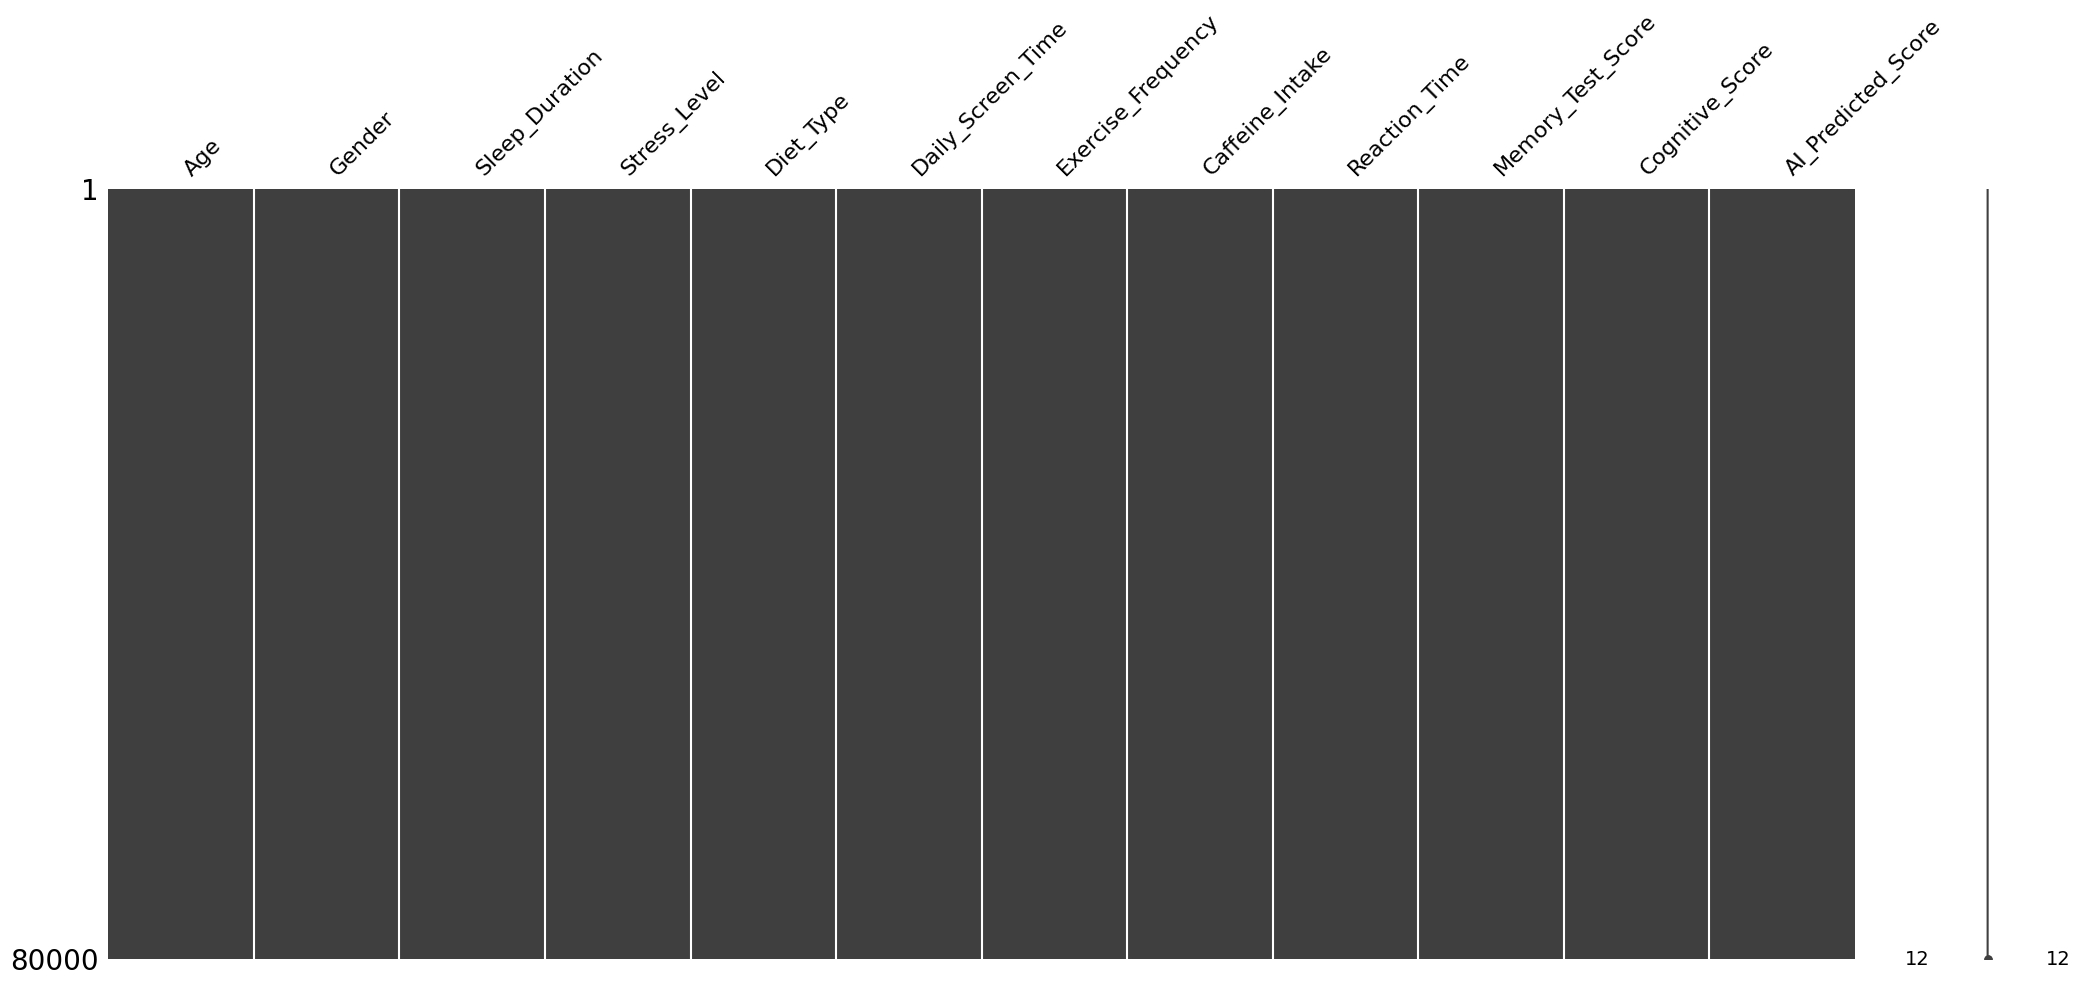

In [9]:
msno.matrix(df)

Here we divide the dataset in to two versions, one which has 5 collumns and has the retains the most information regarding the final varialbe and the regular 10 column version.  The analaysis of the variables is done after this, but this is here just for easier starting of the project while training. 

In [3]:
cs = 'Cognitive_Score'
ai = 'AI_Predicted_Score'
drop_5=['Age','Sleep_Duration','Gender','Caffeine_Intake','Diet_Type',cs,ai]
y  = df[cs]
X  = df.drop(columns=[cs, ai])
X_5=df.drop(columns=drop_5)


Visualisation of how the data is and how we will be processing it.

In [4]:
def preprocess_10(df, target_cols=["Cognitive_Score", "AI_Predicted_Score"]):
    
    numeric_features = df.select_dtypes(include=[np.number]).drop(columns=target_cols, errors="ignore").columns.tolist()
    ordinal_features = ['Exercise_Frequency']
    nominal_features = ['Gender', 'Diet_Type']
    
    ordinal_categories = [['Low', 'Medium', 'High']]
    
    column_transformer = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
        ('nom', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), nominal_features)
    ])
    
    X = df[numeric_features + ordinal_features + nominal_features]
    X_transformed = column_transformer.fit_transform(X)
    all_features = numeric_features + ordinal_features + nominal_features
    
    return pd.DataFrame(X_transformed, columns=all_features)

In [5]:
x_10_without_y = preprocess_10(X)
x_10_without_y.head()

,Age,Sleep_Duration,Stress_Level,Daily_Screen_Time,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Exercise_Frequency,Gender,Diet_Type
0,1.526589,-0.291355,-0.870335,-0.001467,-1.438956,1.589309,-0.259937,1.0,0.0,0.0
1,0.039207,0.342862,1.223694,1.356263,-0.242064,-0.275063,-0.664431,2.0,0.0,0.0
2,-1.035013,0.688798,0.176679,-0.254068,1.245402,0.392103,-1.184496,0.0,1.0,2.0
3,-0.539219,0.458174,1.223694,0.566885,1.487548,-0.985048,1.415826,0.0,1.0,2.0
4,0.948163,1.553638,-1.219340,1.514138,0.802622,-1.407000,-0.433292,1.0,1.0,0.0


In [6]:
drop_for_5=['Age','Sleep_Duration','Gender','Caffeine_Intake','Diet_Type']

In [7]:
x_5=x_10_without_y.drop(columns=drop_for_5)

In [8]:
x_5.head()

,Stress_Level,Daily_Screen_Time,Reaction_Time,Memory_Test_Score,Exercise_Frequency
0,-0.870335,-0.001467,1.589309,-0.259937,1.0
1,1.223694,1.356263,-0.275063,-0.664431,2.0
2,0.176679,-0.254068,0.392103,-1.184496,0.0
3,1.223694,0.566885,-0.985048,1.415826,0.0
4,-1.219340,1.514138,-1.407000,-0.433292,1.0


Here are the visuasilations of the distributions of the dataset.

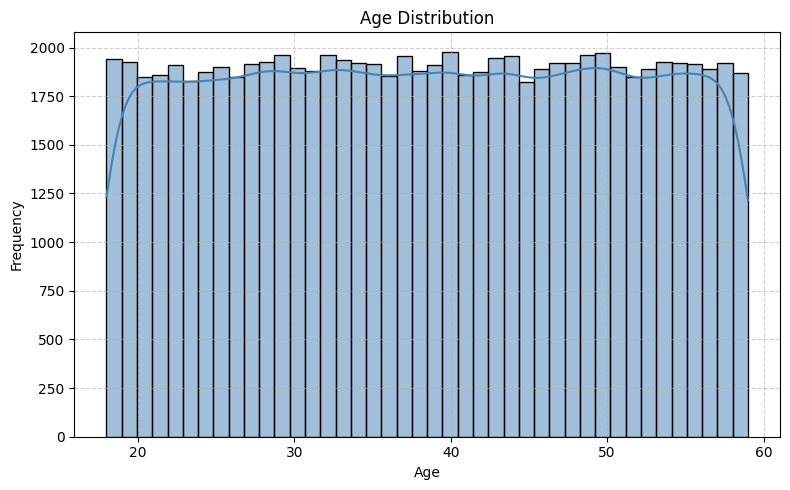

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], kde=True, bins=42, color='steelblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [13]:
age_stats = df['Age'].describe()
print(age_stats)

print("Skewness:", df['Age'].skew())
print("Kurtosis:", df['Age'].kurt())

count    80000.000000
mean        38.525525
std         12.101876
min         18.000000
25%         28.000000
50%         39.000000
75%         49.000000
max         59.000000
Name: Age, dtype: float64
Skewness: -0.0036218544221456846
Kurtosis: -1.1967270989742833


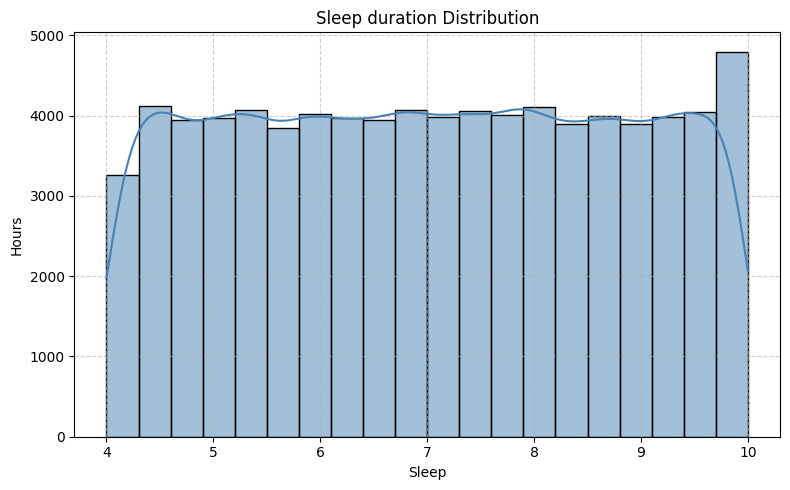

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Sleep_Duration'], kde=True, bins=20, color='steelblue')
plt.title("Sleep duration Distribution")
plt.xlabel("Sleep")
plt.ylabel("Hours")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [15]:
sleep_stats = df['Sleep_Duration'].describe()
print(sleep_stats)

print("Skewness:", df['Age'].skew())
print("Kurtosis:", df['Age'].kurt())

count    80000.000000
mean         7.005333
std          1.734435
min          4.000000
25%          5.500000
50%          7.000000
75%          8.500000
max         10.000000
Name: Sleep_Duration, dtype: float64
Skewness: -0.0036218544221456846
Kurtosis: -1.1967270989742833


/tmp/ipykernel_36988/125980725.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Stress_Level', data=df, palette='viridis')


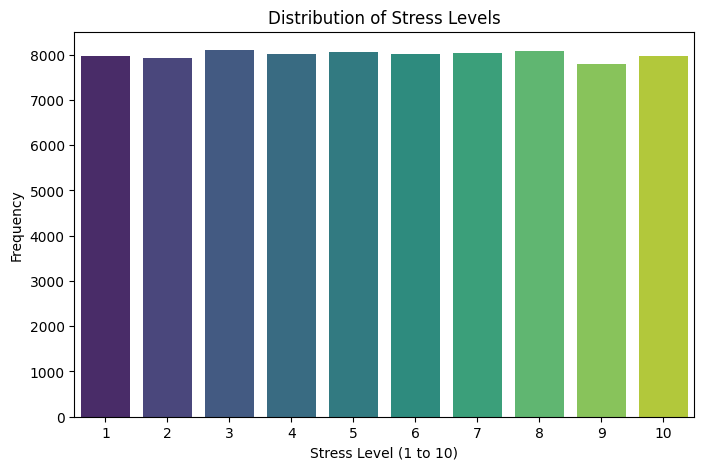

In [16]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Stress_Level', data=df, palette='viridis')
plt.title('Distribution of Stress Levels')
plt.xlabel('Stress Level (1 to 10)')
plt.ylabel('Frequency')
plt.show()

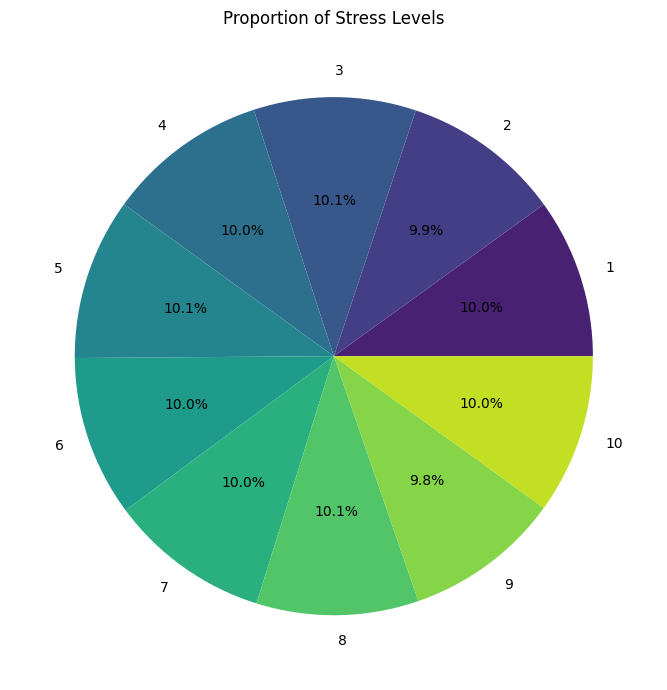

In [17]:
plt.figure(figsize=(7, 7))
df['Stress_Level'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('viridis', 10))
plt.title('Proportion of Stress Levels')
plt.ylabel('')
plt.tight_layout()
plt.show()


In [18]:
stress_stats = df['Stress_Level'].describe()
print(stress_stats)

print("Skewness:", df['Stress_Level'].skew())
print("Kurtosis:", df['Stress_Level'].kurt())

count    80000.000000
mean         5.493762
std          2.865308
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         10.000000
Name: Stress_Level, dtype: float64
Skewness: 0.0034659674154224763
Kurtosis: -1.21759077255955


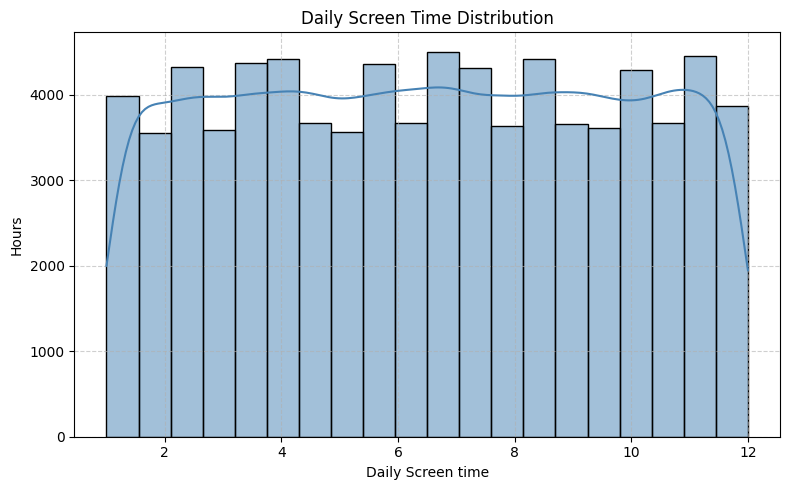

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Daily_Screen_Time'], kde=True, bins=20, color='steelblue')
plt.title("Daily Screen Time Distribution")
plt.xlabel("Daily Screen time")
plt.ylabel("Hours")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [20]:
daily_screntime_stats = df['Daily_Screen_Time'].describe()
print(daily_screntime_stats)

print("Skewness:", df['Daily_Screen_Time'].skew())
print("Kurtosis:", df['Daily_Screen_Time'].kurt())

count    80000.000000
mean         6.504646
std          3.167072
min          1.000000
25%          3.800000
50%          6.500000
75%          9.200000
max         12.000000
Name: Daily_Screen_Time, dtype: float64
Skewness: -0.002413304053149496
Kurtosis: -1.193317693153497


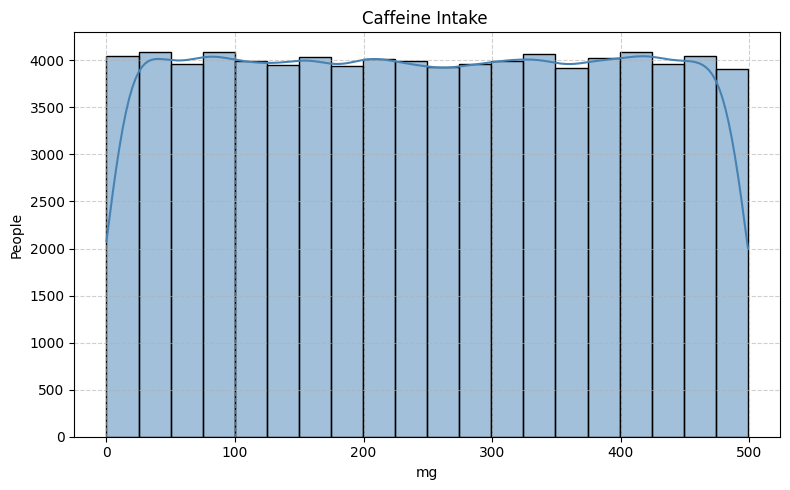

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Caffeine_Intake'], kde=True, bins=20, color='steelblue')
plt.title("Caffeine Intake ")
plt.xlabel("mg")
plt.ylabel("People")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [22]:
caffeine_intake_stats = df['Caffeine_Intake'].describe()
print(caffeine_intake_stats)

print("Skewness:", df['Caffeine_Intake'].skew())
print("Kurtosis:", df['Caffeine_Intake'].kurt())

count    80000.000000
mean       248.988213
std        144.541990
min          0.000000
25%        123.000000
50%        249.000000
75%        375.000000
max        499.000000
Name: Caffeine_Intake, dtype: float64
Skewness: 0.0007968618749813825
Kurtosis: -1.2056316888797207


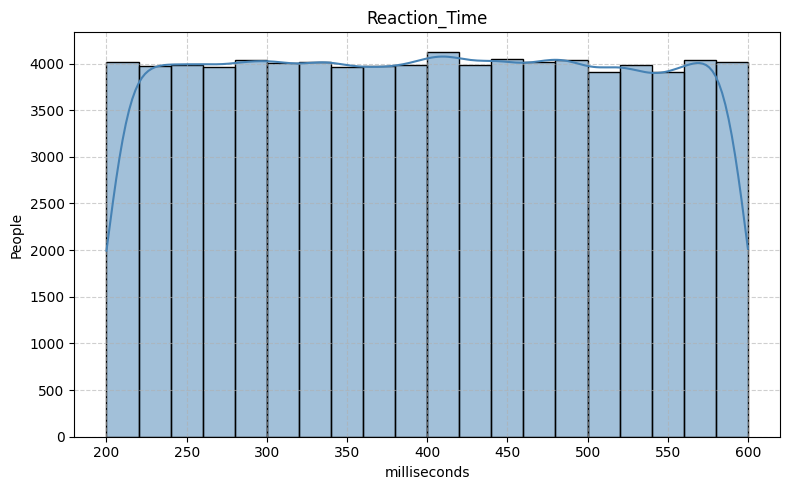

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Reaction_Time'], kde=True, bins=20, color='steelblue')
plt.title("Reaction_Time")
plt.xlabel("milliseconds")
plt.ylabel("People")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [24]:
reaction_time_stats = df['Reaction_Time'].describe()
print(reaction_time_stats)

print("Skewness:", df['Reaction_Time'].skew())
print("Kurtosis:", df['Reaction_Time'].kurt())

count    80000.000000
mean       399.973579
std        115.369329
min        200.000000
25%        300.150000
50%        400.360000
75%        499.250000
max        599.990000
Name: Reaction_Time, dtype: float64
Skewness: 0.002032159172292722
Kurtosis: -1.1952298915324235


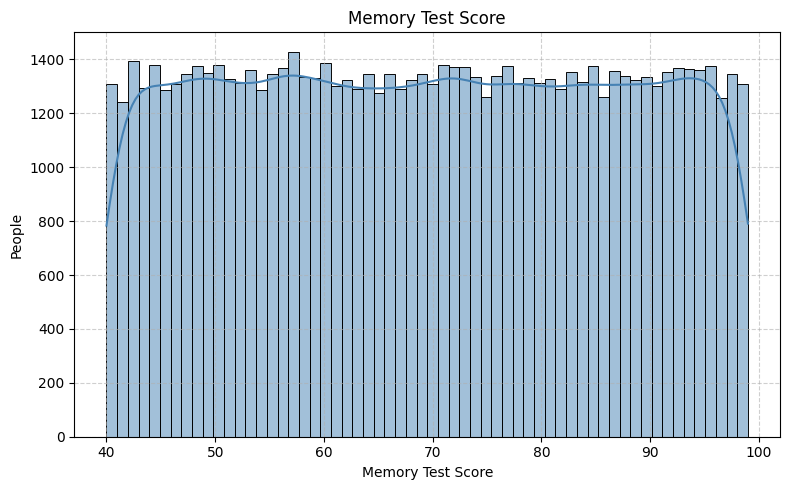

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Memory_Test_Score'], kde=True, bins=60, color='steelblue')
plt.title("Memory Test Score")
plt.xlabel("Memory Test Score")
plt.ylabel("People")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [26]:
memory_test_score_stats = df['Memory_Test_Score'].describe()
print(memory_test_score_stats)

print("Skewness:", df['Memory_Test_Score'].skew())
print("Kurtosis:", df['Memory_Test_Score'].kurt())

count    80000.000000
mean        69.498350
std         17.305659
min         40.000000
25%         55.000000
50%         70.000000
75%         85.000000
max         99.000000
Name: Memory_Test_Score, dtype: float64
Skewness: 0.0032658425823374987
Kurtosis: -1.2028839825242061


/tmp/ipykernel_36988/3113589743.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, palette='viridis')


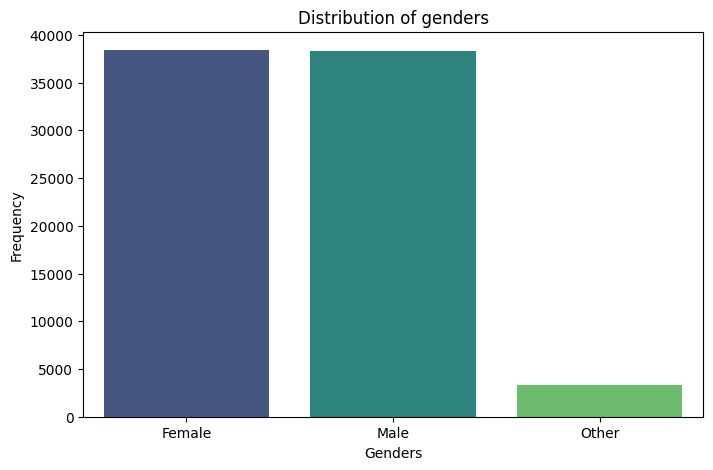

In [27]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', data=df, palette='viridis')
plt.title('Distribution of genders')
plt.xlabel('Genders')
plt.ylabel('Frequency')
plt.show()

In [28]:
diet_counts = df['Gender'].value_counts()
gender_percentages = (diet_counts / len(df)) * 100

print(gender_percentages)


Gender
Female    48.0050
Male      47.9025
Other      4.0925
Name: count, dtype: float64


In [29]:
diet_counts = df['Gender'].value_counts()
gender_percentages = (diet_counts / len(df)) * 100
gender_mode = df['Gender'].mode()[0]
gender_entropy = entropy(diet_counts, base=2)
print("Counts:\n", diet_counts)
print("\nPercentages:\n", gender_percentages.round(2))
print("\nMode:", gender_mode)
print("\nEntropy: {:.4f} bits".format(gender_entropy))

Counts:
 Gender
Female    38404
Male      38322
Other      3274
Name: count, dtype: int64

Percentages:
 Gender
Female    48.00
Male      47.90
Other      4.09
Name: count, dtype: float64

Mode: Female

Entropy: 1.2056 bits


/tmp/ipykernel_36988/755650756.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diet_Type', data=df, palette='viridis')


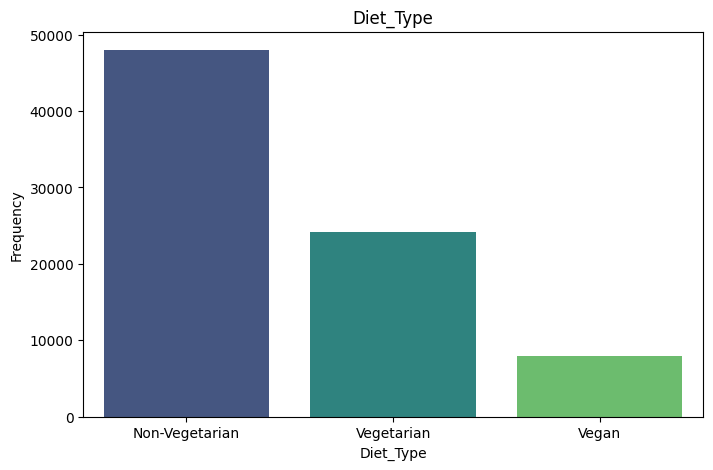

In [30]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Diet_Type', data=df, palette='viridis')
plt.title('Diet_Type')
plt.xlabel('Diet_Type')
plt.ylabel('Frequency')
plt.show()

In [31]:
diet_counts = df['Diet_Type'].value_counts()
diet_percentages = (diet_counts / len(df)) * 100
diet_mode = df['Diet_Type'].mode()[0]
diet_entropy = entropy(diet_counts, base=2)
print("Counts:\n", diet_counts)
print("\nPercentages:\n", diet_percentages.round(2))
print("\nMode:", diet_mode)
print("\nEntropy: {:.4f} bits".format(diet_entropy))

Counts:
 Diet_Type
Non-Vegetarian    47986
Vegetarian        24136
Vegan              7878
Name: count, dtype: int64

Percentages:
 Diet_Type
Non-Vegetarian    59.98
Vegetarian        30.17
Vegan              9.85
Name: count, dtype: float64

Mode: Non-Vegetarian

Entropy: 1.2932 bits


/tmp/ipykernel_36988/3218894701.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Exercise_Frequency', data=df, palette='viridis')


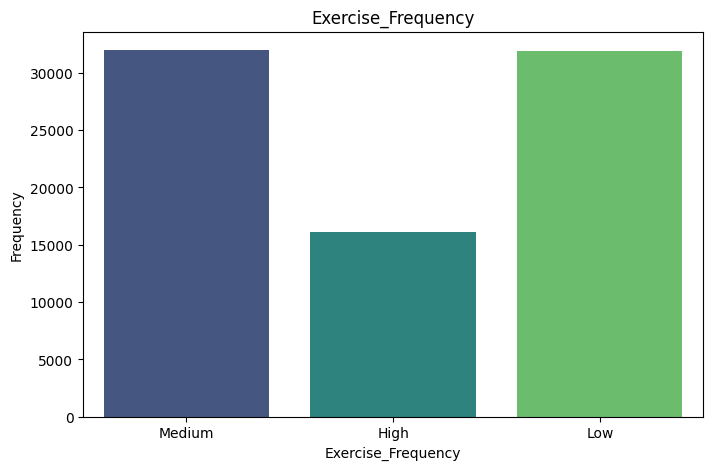

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Exercise_Frequency', data=df, palette='viridis')
plt.title('Exercise_Frequency')
plt.xlabel('Exercise_Frequency')
plt.ylabel('Frequency')
plt.show()

In [33]:
exercise_counts = df['Exercise_Frequency'].value_counts()
exercise_percentages = (exercise_counts / len(df)) * 100
exercise_mode = df['Exercise_Frequency'].mode()[0]
exercise_entropy = entropy(exercise_counts, base=2)
print("Counts:\n", exercise_counts)
print("\nPercentages:\n", exercise_percentages.round(2))
print("\nMode:", exercise_mode)
print("\nEntropy: {:.4f} bits".format(exercise_entropy))

Counts:
 Exercise_Frequency
Medium    31990
Low       31896
High      16114
Name: count, dtype: int64

Percentages:
 Exercise_Frequency
Medium    39.99
Low       39.87
High      20.14
Name: count, dtype: float64

Mode: Medium

Entropy: 1.5233 bits


Error Summary Statistics:
        Absolute_Error
count    80000.000000
mean         2.448780
std          1.468794
min          0.000000
25%          1.180000
50%          2.450000
75%          3.720000
max          5.000000

Pearson correlation: 0.9924
Spearman correlation: 0.9926


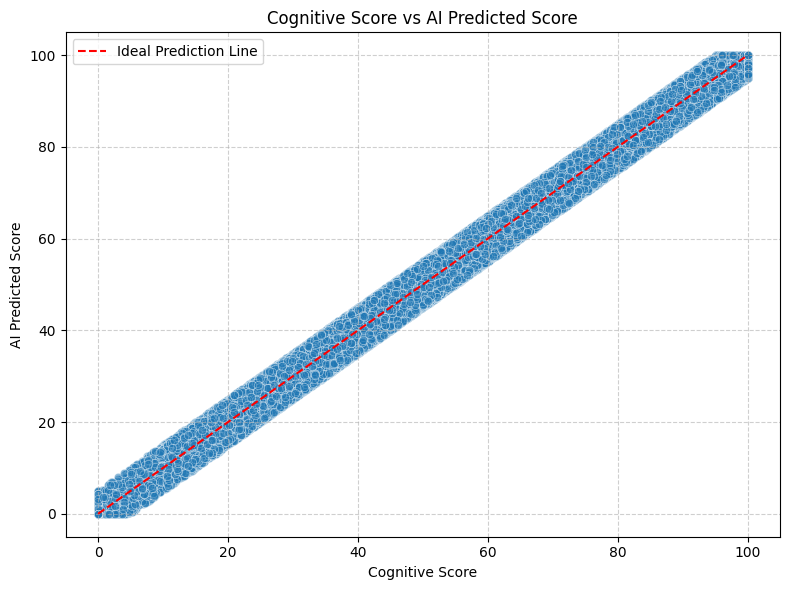

In [34]:
df['Absolute_Error'] = (df['Cognitive_Score'] - df['AI_Predicted_Score']).abs()


error_summary = df[['Absolute_Error']].describe()
print("Error Summary Statistics:\n", error_summary)

pearson_corr, _ = pearsonr(df['Cognitive_Score'], df['AI_Predicted_Score'])
spearman_corr, _ = spearmanr(df['Cognitive_Score'], df['AI_Predicted_Score'])
print(f"\nPearson correlation: {pearson_corr:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Cognitive_Score', y='AI_Predicted_Score', data=df, alpha=0.5)
plt.plot([df['Cognitive_Score'].min(), df['Cognitive_Score'].max()],
         [df['Cognitive_Score'].min(), df['Cognitive_Score'].max()],
         color='red', linestyle='--', label='Ideal Prediction Line')
plt.xlabel('Cognitive Score')
plt.ylabel('AI Predicted Score')
plt.title('Cognitive Score vs AI Predicted Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
df=df.drop(columns=['Absolute_Error'])

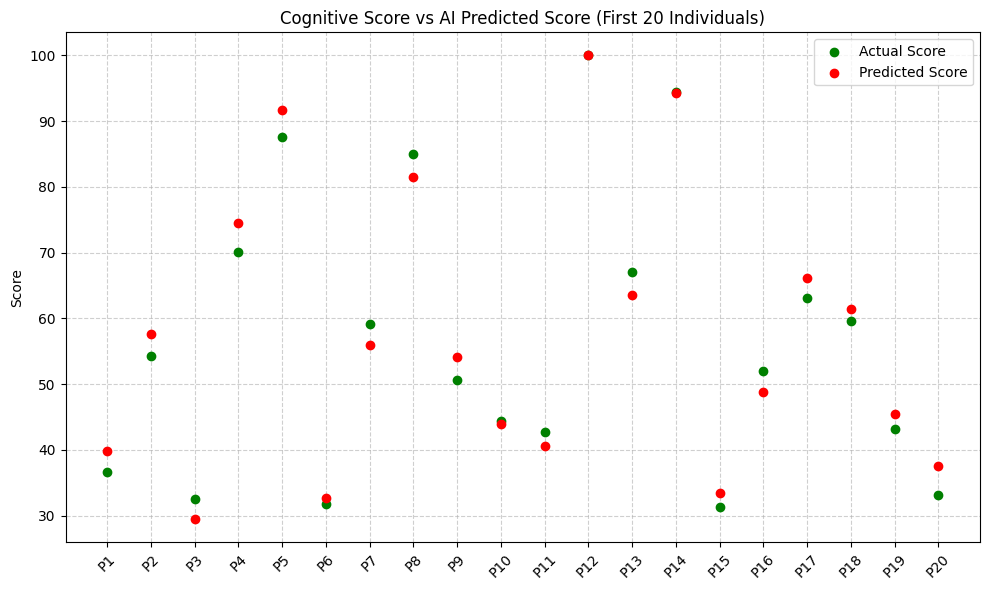

In [35]:
subset = df[['Cognitive_Score', 'AI_Predicted_Score']].head(20)

plt.figure(figsize=(10, 6))
x = range(len(subset))

plt.scatter(x, subset['Cognitive_Score'], color='green', label='Actual Score', zorder=2)

plt.scatter(x, subset['AI_Predicted_Score'], color='red', label='Predicted Score', zorder=2)


plt.xticks(x, [f'P{i+1}' for i in x], rotation=45)
plt.ylabel('Score')
plt.title('Cognitive Score vs AI Predicted Score (First 20 Individuals)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6, zorder=1)
plt.tight_layout()
plt.show()


Visualisations of the variables and how they affect the target variable.

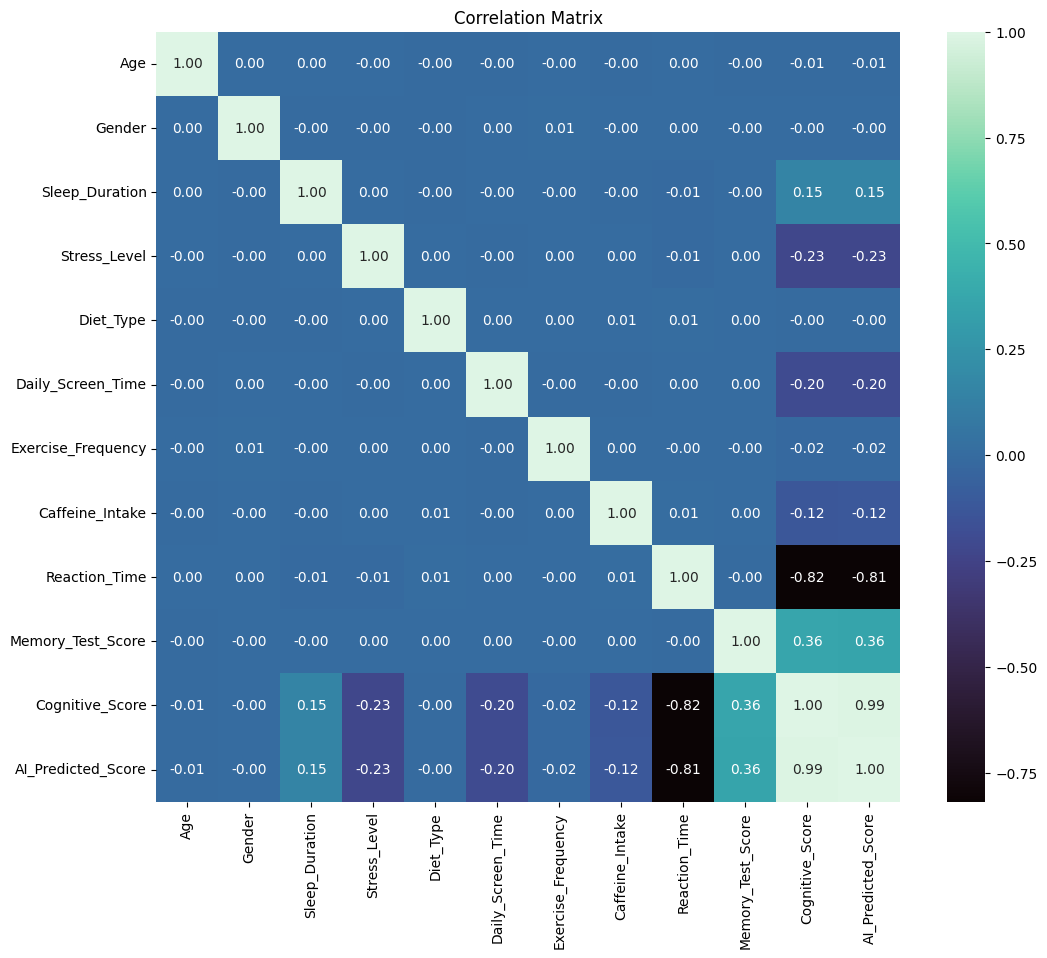

In [38]:
df_encoded = df.copy()
for col in df.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df[col])

correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="mako")
plt.title("Correlation Matrix")
plt.show()

In [91]:
df

,Age,Gender,Sleep_Duration,Stress_Level,Diet_Type,Daily_Screen_Time,Exercise_Frequency,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Cognitive_Score,AI_Predicted_Score
0,57,Female,6.5,3,Non-Vegetarian,6.5,Medium,41,583.33,65,36.71,39.77
1,39,Female,7.6,9,Non-Vegetarian,10.8,High,214,368.24,58,54.35,57.68
2,26,Male,8.2,6,Vegetarian,5.7,Low,429,445.21,49,32.57,29.54
3,32,Male,7.8,9,Vegetarian,8.3,Low,464,286.33,94,70.15,74.59
4,50,Male,9.7,2,Non-Vegetarian,11.3,Medium,365,237.65,62,87.54,91.78
...,...,...,...,...,...,...,...,...,...,...,...,...
79995,55,Male,7.8,9,Non-Vegetarian,9.4,Low,157,312.34,55,50.80,46.49
79996,35,Female,9.8,6,Vegetarian,6.5,Medium,130,290.17,86,94.89,92.41
79997,32,Female,7.3,10,Non-Vegetarian,7.5,Low,462,249.57,72,63.51,67.35
79998,34,Male,8.7,8,Vegetarian,7.2,Medium,96,319.48,82,81.43,77.95


Here we havea  training set which we will use crossvalidation for the training and a witheld test dataset that we will be using so that we can evaluate the final model. 

In [8]:
#x_10=pd.concat([x_10_without_y.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
#x_5=pd.concat([x_5_without_y.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(x_10_without_y, y, test_size=0.2, random_state=47)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(x_5, y, test_size=0.2, random_state=47)


In [14]:
def evaluate_model_preprocessed(x, y, model, model_name="Model", cv=5):
    scores = cross_val_score(model, x, y, cv=cv, scoring="r2")
    print(f"[{model_name}] R²: {scores.mean():.4f} ± {scores.std():.4f}")

In [119]:
evaluate_model_preprocessed(x_train_5,y_train_5,LinearRegression(),model_name='LinearRegression 5')
evaluate_model_preprocessed(x_train_10,y_train_10,LinearRegression(),model_name='LinearRegression 10')
evaluate_model_preprocessed(x_train_5,y_train_5,RidgeCV(),model_name='RidgeCV 5')
evaluate_model_preprocessed(x_train_10,y_train_10,RidgeCV(),model_name='RidgeCV 10')

[LinearRegression 5] R²: 0.9574 ± 0.0004
[LinearRegression 10] R²: 0.9929 ± 0.0003
[RidgeCV 5] R²: 0.9574 ± 0.0004
[RidgeCV 10] R²: 0.9929 ± 0.0003


In [121]:
def get_best_using_ridge(x,y):
    ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)


    ridge_cv.fit(x, y)

    coefs = ridge_cv.coef_

    if hasattr(X, 'columns'):
        feature_names = X.columns
    else:
        feature_names = [f"Feature_{i}" for i in range(X.shape[1])]

    top_features = sorted(zip(feature_names, coefs), key=lambda x: abs(x[1]), reverse=True)[:10]

    print("\nTop 10 features (RidgeCV):")
    for name, coef in top_features:
        print(f"  • {name:40s} → coef = {coef:+.4f}")

In [122]:
get_best_using_ridge(x_train_5,y_train_5)
get_best_using_ridge(x_train_10,y_train_10)


Top 10 features (RidgeCV):
  • Stress_Level                             → coef = -18.9277
  • Daily_Screen_Time                        → coef = +8.3836
  • Caffeine_Intake                          → coef = +7.5609
  • Age                                      → coef = -5.5099
  • Sleep_Duration                           → coef = -4.5960

Top 10 features (RidgeCV):
  • Reaction_Time                            → coef = -18.8814
  • Memory_Test_Score                        → coef = +8.3837
  • Exercise_Frequency                       → coef = +7.5874
  • Stress_Level                             → coef = -5.5222
  • Daily_Screen_Time                        → coef = -4.5963
  • Sleep_Duration                           → coef = +3.3402
  • Caffeine_Intake                          → coef = -2.7788
  • Diet_Type                                → coef = +0.0185
  • Gender                                   → coef = +0.0086
  • Age                                      → coef = -0.0031


In [134]:
def get_best_using_tree(x,y):
    tree_model = DecisionTreeRegressor(max_depth=10, random_state=47)
    tree_model.fit(x, y)

    importances = tree_model.feature_importances_

    
    if hasattr(x, 'columns'):
        feature_names = x.columns
    else:
        feature_names = [f"Feature_{i}" for i in range(x.shape[1])]

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    importance_df = importance_df[importance_df["Importance"] > 0]

    print(importance_df.to_string(index=False))


In [135]:
get_best_using_tree(x_train_5,y_train_5)
get_best_using_tree(x_train_10,y_train_10)

           Feature  Importance
     Reaction_Time    0.708248
 Memory_Test_Score    0.134717
Exercise_Frequency    0.063680
      Stress_Level    0.055937
 Daily_Screen_Time    0.037418
           Feature  Importance
     Reaction_Time    0.698195
 Memory_Test_Score    0.131681
Exercise_Frequency    0.061030
      Stress_Level    0.050479
 Daily_Screen_Time    0.033813
    Sleep_Duration    0.016835
   Caffeine_Intake    0.007958
               Age    0.000008


In [ ]:
def visualise_pca(x): 
    pca = PCA()
    pca.fit(x)
    eigenvalues = pca.explained_variance_

    components = np.arange(1, len(eigenvalues) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(components, eigenvalues, 'o-', label='Eigenvalue')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot with Elbow Detection')

    kl = KneeLocator(components, eigenvalues, curve='concave', direction='decreasing')
    elbow_pc = kl.knee
    explained = pca.explained_variance_ratio_
    cumulative = explained.cumsum()
    df_evr = pd.DataFrame({
        'PC': [f'PC{i+1}' for i in range(len(explained))],
        'Explained Variance Ratio': explained,
        'Cumulative Variance Ratio': cumulative
    })
    
    print(df_evr)  
    
    if elbow_pc is not None:
        plt.vlines(elbow_pc, plt.ylim()[0], plt.ylim()[1],
                linestyles='--', colors='red',
                label=f'Elbow at PC#{elbow_pc}')
        print(f"--> Elbow detected at principal component #{elbow_pc}")
    else:
        print("--> No clear elbow detected; you may need to inspect the plot manually.")

    plt.legend()
    plt.grid(True)
    plt.xticks(components)
    plt.tight_layout()
    plt.show()


    PC  Explained Variance Ratio  Cumulative Variance Ratio
0  PC1                  0.222594                   0.222594
1  PC2                  0.219992                   0.442586
2  PC3                  0.217758                   0.660344
3  PC4                  0.216523                   0.876866
4  PC5                  0.123134                   1.000000
--> Elbow detected at principal component #4


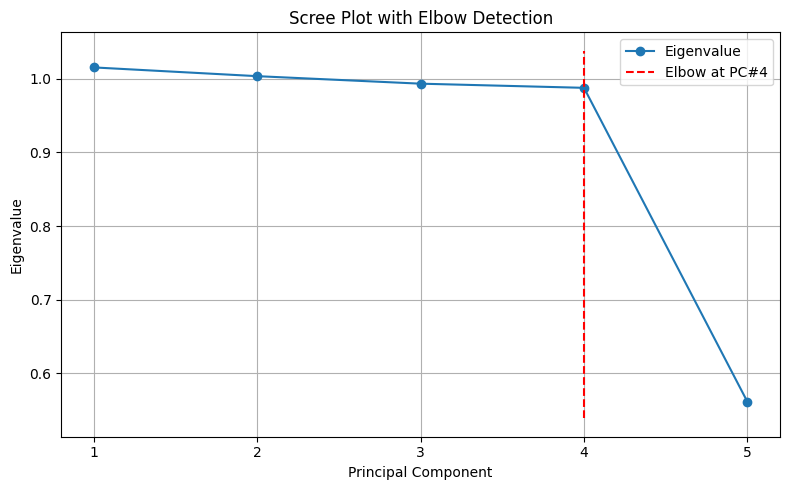

     PC  Explained Variance Ratio  Cumulative Variance Ratio
0   PC1                  0.117427                   0.117427
1   PC2                  0.115749                   0.233177
2   PC3                  0.115453                   0.348629
3   PC4                  0.114882                   0.463511
4   PC5                  0.114118                   0.577630
5   PC6                  0.113853                   0.691482
6   PC7                  0.112966                   0.804448
7   PC8                  0.093347                   0.897795
8   PC9                  0.064517                   0.962311
9  PC10                  0.037689                   1.000000
--> Elbow detected at principal component #7


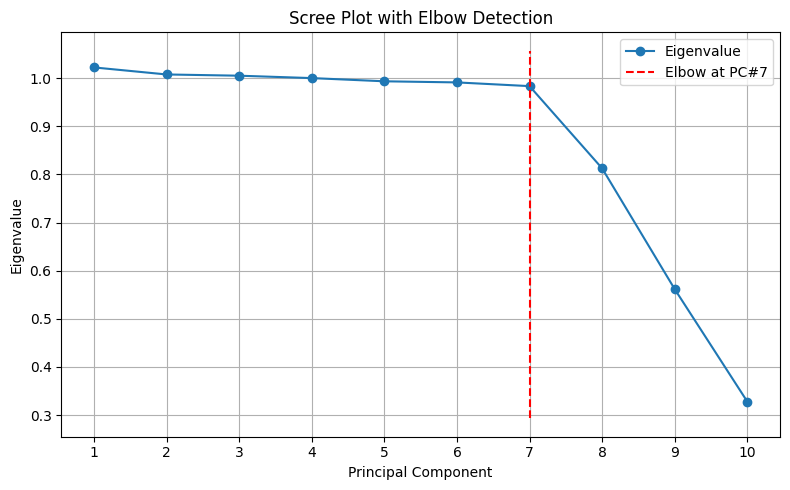

In [146]:
visualise_pca(x_train_5)
visualise_pca(x_train_10)

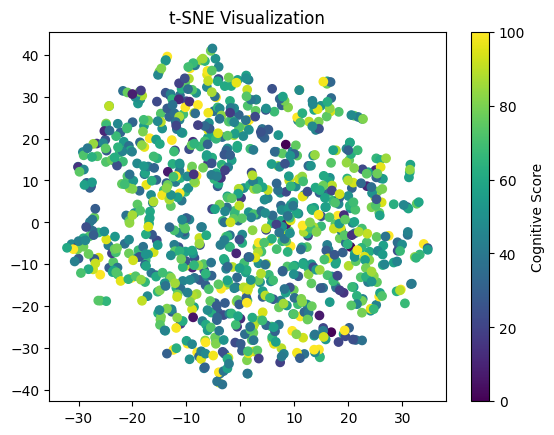

In [147]:

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(x_train_10[:1000])

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:1000], cmap='viridis')
plt.title("t-SNE Visualization")
plt.colorbar(label='Cognitive Score')
plt.show()


In [151]:
def compute_mutual_info(x, y):
    
    mi = mutual_info_regression(x, y, random_state=47)
    numeric_cols = x.select_dtypes(include=['number']).columns.tolist()
    mi_series = pd.Series(mi, index=numeric_cols ).sort_values(ascending=False)

    print(mi_series)

In [153]:
compute_mutual_info(x_train_10,y_train_10)

Reaction_Time         0.542706
Memory_Test_Score     0.076766
Exercise_Frequency    0.033041
Stress_Level          0.030903
Daily_Screen_Time     0.021959
Sleep_Duration        0.012530
Caffeine_Intake       0.008068
Diet_Type             0.000511
Age                   0.000104
Gender                0.000000
dtype: float64


From all of the analysis and feature extraction we have done, we will train our model on 3 types of data.
The datasets are divided as the following:
-10, has all of the data
-7, has the 7 most expressive columns.
-5 has the 5 most expressive columns.

Models 

In [9]:
x_7 = x_10_without_y.drop(columns=['Diet_Type','Age','Gender'])

In [11]:
x_7.head()

,Sleep_Duration,Stress_Level,Daily_Screen_Time,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Exercise_Frequency
0,-0.291355,-0.870335,-0.001467,-1.438956,1.589309,-0.259937,1.0
1,0.342862,1.223694,1.356263,-0.242064,-0.275063,-0.664431,2.0
2,0.688798,0.176679,-0.254068,1.245402,0.392103,-1.184496,0.0
3,0.458174,1.223694,0.566885,1.487548,-0.985048,1.415826,0.0
4,1.553638,-1.219340,1.514138,0.802622,-1.407000,-0.433292,1.0


In [10]:
x_train_7, x_test_7, y_train_7, y_test_7 = train_test_split(x_7, y, test_size=0.2, random_state=47)

These models we will use as a baseline. 

In [183]:
def baseline_cv(x, y, model, model_name='blank',cv=5):
    r2_scores = cross_val_score(model, x, y, cv=cv, scoring='r2')
    mean_r2 = r2_scores.mean()
    
    neg_rmse_scores = cross_val_score(model, x, y, cv=cv, scoring='neg_root_mean_squared_error')
    mean_rmse = -neg_rmse_scores.mean()
    
    model.fit(x, y)
    y_pred = model.predict(x)
    overall_r2 = r2_score(y, y_pred)
    overall_rmse = mean_squared_error(y, y_pred) 
    
    print(f"Model: {model_name}")
    print(f"Mean CV RMSE: {mean_rmse:.4f}")
    print(f"Mean CV R2: {mean_r2:.4f}")
    print(f"Overall R2: {overall_r2:.4f}")
    print(f"Overall RMSE: {overall_rmse:.4f}\n")
    

In [184]:
model=LinearRegression()
baseline_cv(x_train_5,y_train_5,model,'LinearRegression')
baseline_cv(x_train_7,y_train_7,model,'LinearRegression')
baseline_cv(x_train_10,y_train_10,model,'LinearRegression')



Model: LinearRegression
Mean CV RMSE: 4.7603
Mean CV R2: 0.9574
Overall R2: 0.9574
Overall RMSE: 22.6576

Model: LinearRegression
Mean CV RMSE: 1.9387
Mean CV R2: 0.9929
Overall R2: 0.9929
Overall RMSE: 3.7595

Model: LinearRegression
Mean CV RMSE: 1.9387
Mean CV R2: 0.9929
Overall R2: 0.9929
Overall RMSE: 3.7592



In [185]:
model=RidgeCV(alphas= np.logspace(-6, 3, 50),scoring='r2')
baseline_cv(x_train_5,y_train_5,model,'RidgeRegression')
baseline_cv(x_train_7,y_train_7,model,'RidgeRegression')
baseline_cv(x_train_10,y_train_10,model,'RidgeRegression')



Model: RidgeRegression
Mean CV RMSE: 4.7603
Mean CV R2: 0.9574
Overall R2: 0.9574
Overall RMSE: 22.6576

Model: RidgeRegression
Mean CV RMSE: 1.9387
Mean CV R2: 0.9929
Overall R2: 0.9929
Overall RMSE: 3.7595

Model: RidgeRegression
Mean CV RMSE: 1.9387
Mean CV R2: 0.9929
Overall R2: 0.9929
Overall RMSE: 3.7592



Grid Search,Random Search, Bayes Search, Simulated Anealing, PSO. 
Hill climbing,Genetic algorithm Ant collony optimization, Artifical Bee Colony, Optuna.

Extra Trees Regressor

Here i will be defining the Extra Trees hyperparameters which we will be searching for. 
- max_depth = [5:10]
- min_samples_leaf = [5:15]
- n_estimators = [50:300]
- min_samples_split = [2:20]

In [13]:
extra_tree_bounds= [(5, 10),(5,15),(50, 300), (2,20)]

In [12]:
def evaluate_hill(params, x, y, cv=3, random_state=47):
    model = ExtraTreesRegressor(**params, random_state=random_state, n_jobs=-1)
    scores = cross_val_score(model, x, y, cv=cv, scoring='r2', n_jobs=-1)
    return np.mean(scores)

In [13]:
def hill_climbing(x, y, param_space, cv=3, max_iter=30, random_state=300):
    
    random.seed(random_state)
    np.random.seed(random_state)

    bounds = {}
    for k, v in param_space.items():
        if isinstance(v, tuple) and all(isinstance(i, (int, float)) for i in v):
            bounds[k] = (v[0], v[1] - 1)
        else:
            raise ValueError(f"Unsupported param type or format for '{k}': {v}")

    current = {
        k: random.randint(int(v[0]), int(v[1]))
        for k, v in bounds.items()
    }

    current_score = evaluate_hill(current, x, y, cv=cv, random_state=random_state)

    visited = set()
    visited.add(tuple(sorted(current.items())))

    for iteration in range(max_iter):
        neighbors = []

        for param in current:
            for change in [-1, 1]:
                neighbor = current.copy()
                new_val = neighbor[param] + change

                low, high = bounds[param]
                if low <= new_val <= high:
                    neighbor[param] = new_val
                    neighbor_tuple = tuple(sorted(neighbor.items()))
                    if neighbor_tuple not in visited:
                        neighbors.append(neighbor)
                        visited.add(neighbor_tuple)

        if not neighbors:
            #print(f"Iter {iteration + 1}: No new neighbors to explore, stopping.")
            break

        neighbor_scores = []
        for neigh in neighbors:
            score = evaluate_hill(neigh, x, y, cv=cv, random_state=random_state)
            neighbor_scores.append((score, neigh))

        best_neighbor_score, best_neighbor = max(neighbor_scores, key=lambda b: b[0])

        if best_neighbor_score > current_score:
            current, current_score = best_neighbor, best_neighbor_score
            #print(f"Iter {iteration + 1}: Improved score to {current_score:.4f} with params {current}")
        else:
            print(f"Best model {current}")
            print(f"Iter {iteration + 1}: No improvement, stopping.")
            break

    
    return  current, current_score


In [17]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.optimize import dual_annealing

def sa_progress_callback(x, f, context, param_names, param_bounds):
    params = build_param_dict(param_names, param_bounds, x)
    print(f"Current best score: {-f:.4f} with params: {params}")
def build_param_dict(param_names, param_bounds, x):
    return {
        name: int(val) if isinstance(param_bounds[name][0], int) else val
        for name, val in zip(param_names, x)
    }

def make_cv(cv, random_state):
    if isinstance(cv, int):
        return KFold(n_splits=cv, shuffle=True, random_state=random_state)
    else:
        return cv

def objective_function(params_vector, model_class, param_names, param_bounds,
                       x, y, metric_fn, fit_kwargs, cv=3, random_state=47):
    params = build_param_dict(param_names, param_bounds, params_vector)
    if random_state is not None:
        if 'random_state' in model_class().get_params():
            params['random_state'] = random_state
    try:
        model = model_class(**params)
        score = cross_val_score(
            model, x, y, scoring=metric_fn,
            cv=make_cv(cv, random_state),n_jobs=-1
        ).mean()
        return -score
    except Exception as e:
        print("Error with params:", params, "\nException:", e)
        return float("inf")

def sa_hyperparameter_tuning(model_class, param_bounds, x, y, metric_fn,
                             fit_kwargs={}, cv=5, random_state=47,max_iter=100):

    param_names = list(param_bounds.keys())
    bounds = list(param_bounds.values())

    """def sa_progress_callback(x, f, context):
        params = build_param_dict(param_names, param_bounds, x)
        print(f" Score: {-f:.4f}, Params: {params}")
        """

    result = dual_annealing(
        objective_function,
        bounds,
        args=(model_class, param_names, param_bounds, x, y, metric_fn, fit_kwargs, cv, random_state),
        seed=random_state,
        maxiter=max_iter
    )
    """ result = dual_annealing(
        objective_function,
        bounds,
        args=(model_class, param_names, param_bounds, x, y, metric_fn, fit_kwargs, cv, random_state),
        seed=random_state,
        callback=sa_progress_callback,maxiter=max_iter
    )"""

    best_params = build_param_dict(param_names, param_bounds, result.x)
    best_score = -result.fun
    return best_params, best_score



In [21]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

In [18]:
def optuna_objective(trial, x, y, model_class, param_space_fn, cv=3, random_state=47, scoring='r2', n_jobs=-1):
    params = param_space_fn(trial)
    
    if 'random_state' in model_class().get_params() and 'random_state' not in params:
        params['random_state'] = random_state

    model = model_class(**params)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, x, y, cv=kf, scoring=scoring, n_jobs=n_jobs)
    return np.mean(scores)

def optuna_tune_model(x, y, model_class, param_space_fn, cv=3, n_trials=30, random_state=47, scoring='r2', n_jobs=-1):
    study = optuna.create_study(direction='maximize' if scoring != 'neg_mean_squared_error' else 'minimize')
    study.optimize(lambda trial: optuna_objective(trial, x, y, model_class, param_space_fn, cv, random_state, scoring, n_jobs),
                   n_trials=n_trials, n_jobs=1)

    best_params = study.best_trial.params

    best_model = model_class(random_state=random_state, **best_params)
    best_model.fit(x, y)
    best_score = study.best_trial.value
    return  best_params, best_score

def extratrees_param_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
    }

In [19]:
def generic_param_space(trial, param_config):
    params = {}
    for param_name, value in param_config.items():
        if isinstance(value, (list, tuple)) and len(value) > 2:
            # Categorical
            params[param_name] = trial.suggest_categorical(param_name, value)
        elif isinstance(value, (list, tuple)) and len(value) == 2:
            low, high = value
            if isinstance(low, float) or isinstance(high, float):
                params[param_name] = trial.suggest_float(param_name, low, high)
            else:
                params[param_name] = trial.suggest_int(param_name, low, high)
        else:
            raise ValueError(f"Unsupported param format for {param_name}: {value}")
    return params


def optuna_objective(trial, x, y, model_class, param_config, cv=3, random_state=47, scoring='r2', n_jobs=-1):
    params = generic_param_space(trial, param_config)

    if 'random_state' in model_class().get_params() and 'random_state' not in params:
        params['random_state'] = random_state

    model = model_class(**params)
    if 'n_jobs' in model.get_params():
        model.set_params(n_jobs=n_jobs)

    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, x, y, cv=kf, scoring=scoring, n_jobs=n_jobs)
    return np.mean(scores)


def optuna_tune_model(x, y, model_class, param_config, cv=3, n_trials=30, random_state=47, scoring='r2', n_jobs=-1):
    study = optuna.create_study(direction='maximize' if scoring != 'neg_mean_squared_error' else 'minimize')

    
    objective = lambda trial: optuna_objective(trial, x, y, model_class, param_config, cv, random_state, scoring, n_jobs)

    study.optimize(objective, n_trials=n_trials, n_jobs=1)

    best_params = study.best_trial.params
    best_model = model_class(**best_params)

    if 'random_state' in best_model.get_params():
        best_model.set_params(random_state=random_state)
    if 'n_jobs' in best_model.get_params():
        best_model.set_params(n_jobs=n_jobs)

    best_model.fit(x, y)
    best_score = study.best_trial.value
    return best_params, best_score


In [21]:
def pso_objective(x, y, model_class, int_params, cat_params, cat_lookup,
                  random_state=47, cv=3, scoring='r2', **params):
   
    for key in int_params:
        params[key] = int(round(params[key]))

    
    for key in cat_params:
        index = int(round(params[key]))
        params[key] = cat_lookup[key][index]

    
    model = model_class(**params)
    cv_split = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, x, y, cv=cv_split, scoring=scoring, n_jobs=-1)
    return scores.mean()

def run_pso_search(x, y, model_class, param_space,
                   num_evals=50, cv=3, scoring='r2', random_state=47):

    param_bounds = {}
    int_params = []
    cat_params = []
    cat_lookup = {}

    for param, values in param_space.items():
        if isinstance(values, tuple) and all(isinstance(v, int) for v in values):
            param_bounds[param] = values
            int_params.append(param)
        elif isinstance(values, tuple) and any(isinstance(v, float) for v in values):
            param_bounds[param] = values  # float param
        elif isinstance(values, (list, tuple)):
            param_bounds[param] = (0, len(values) - 1)
            cat_params.append(param)
            cat_lookup[param] = list(values)
        else:
            raise ValueError(f"Invalid parameter format for {param}: {values}")

    wrapped_obj = lambda **kwargs: pso_objective(
        x, y, model_class,
        int_params=int_params,
        cat_params=cat_params,
        cat_lookup=cat_lookup,
        random_state=random_state,
        cv=cv,
        scoring=scoring,
        **kwargs
    )

    hps, info, _ = optunity.maximize(
        wrapped_obj,
        num_evals=num_evals,
        solver_name='particle swarm',
        **param_bounds
    )

    # Decode final parameters
    final_params = {}
    for k, v in hps.items():
        if k in int_params:
            final_params[k] = int(round(v))
        elif k in cat_params:
            final_params[k] = cat_lookup[k][int(round(v))]
        else:
            final_params[k] = v

    print("Best hyperparameters found by PSO:", final_params)
    print(f"Best average CV R² score: {info.optimum:.4f}")

    return final_params, info.optimum

In [22]:
def make_abc_objective(x, y, keys, cv, random_state):
    def abc_objective(p):
        params = {k: int(v) for k, v in zip(keys, p)}
        model = ExtraTreesRegressor(random_state=random_state, n_jobs=-1, **params)
        score = cross_val_score(model, x, y, cv=cv, scoring='r2', n_jobs=-1)
        return -np.mean(score)
    return abc_objective

In [19]:
def tune_extratrees(x,y,test_x,test_y,param_space,strategy='grid',cv=3,n_iter=30,random_state=47,results_path="results.txt"):
    base=ExtraTreesRegressor(random_state=random_state,n_jobs=-1)
    start=time.time()
    
    if strategy=='grid':
        search=GridSearchCV(base,param_space,cv=cv,scoring='r2',n_jobs=-1)
        search.fit(x,y)
        best_params,best_score=search.best_params_,search.best_score_
    
    elif strategy=='random':
        param_space = {
        'n_estimators': randint(50, 301),        
        'max_depth': randint(5, 11),             
        'min_samples_leaf': randint(5, 16),      
        'min_samples_split': randint(2, 21)      
    }
        search=RandomizedSearchCV(base,param_distributions=param_space,cv=cv,scoring='r2',n_jobs=-1,n_iter=n_iter,random_state=random_state)
        search.fit(x,y)
        best_params,best_score=search.best_params_,search.best_score_      
    
    elif strategy=='bayes':
        search = BayesSearchCV(base, param_space,
                               n_iter=n_iter, cv=cv,
                               scoring="r2",
                               random_state=random_state,
                               n_jobs=-1)
        search.fit(x, y)
        best_params, best_score =  search.best_params_, search.best_score_
    elif strategy=='hill_climbing':
        number_of_restarts=10
        
        best_score=0
        best_params={}
        for i in range(number_of_restarts): 
            random_state=random.randint(0, number_of_restarts*2)
            
            tmp_params, tmp_score=hill_climbing(x,y,param_space,cv=cv,random_state=random_state,max_iter=n_iter)
            if best_score<tmp_score:
                best_score=tmp_score
                best_params=tmp_params
    
    elif  strategy== 'sa': 
        number_of_restarts=10
        base=ExtraTreesRegressor
        best_score=0
        best_params={}
        for i in range(number_of_restarts): 
            random_state=random.randint(0, number_of_restarts*2)
            
            tmp_params, tmp_score=sa_hyperparameter_tuning(base,param_space,x,y,random_state=random_state,metric_fn='r2',max_iter=int(n_iter/number_of_restarts))
            if best_score<tmp_score:
                best_score=tmp_score
                best_params=tmp_params
    elif strategy == 'optuna':
        
        best_params, best_score = optuna_tune_model(
        x, y,
        model_class=ExtraTreesRegressor,
        param_space_fn=extratrees_param_space,
        cv=3,
        n_trials=200,
        random_state=random_state,
        scoring='r2',
        n_jobs=-1
    )
    elif strategy == 'pso':
        
        best_params, best_score = run_pso_search(
        x, y,
        model_class=ExtraTreesRegressor,
        param_bounds=param_space,
        num_evals=50,
        cv=3,
        scoring='r2'
)
    elif strategy=='ga':
        ga_param_space = {
            'n_estimators': GAInteger(50, 300),
            'max_depth': GAInteger(5, 10),
            'min_samples_leaf': GAInteger(1, 15),
            'min_samples_split': GAInteger(2, 10)
        }
        
        search = GASearchCV(
            estimator=ExtraTreesRegressor(random_state=random_state, n_jobs=-1),
            cv=cv,
            scoring='r2',
            param_grid=ga_param_space,  
            population_size=20,
            generations=n_iter,
            n_jobs=-1,
            verbose=True
        )
        search.fit(x, y)
        best_params = search.best_params_
        best_score = search.best_score_
    elif strategy =='abc':
        keys = list(param_space.keys())
        bounds = [param_space[k] for k in keys]

        objective_fn = make_abc_objective(x, y, keys, cv, random_state)

        abc_obj = abc(
            function=objective_fn,
            boundaries=bounds,
            colony_size=40,
            scouts=0.5,
            iterations=n_iter,
            min_max='min',
            nan_protection=True,
            log_agents=False
        )
        abc_obj.fit()

        solution = abc_obj.get_solution()
        best_params = {k: int(v) for k, v in zip(keys, solution)}
        model = ExtraTreesRegressor(random_state=random_state, n_jobs=-1, **best_params)
        model.fit(x, y)
        train_preds = model.predict(x)
        best_score = r2_score(y, train_preds) 
    else:
        raise ValueError(f"Unsupported strategy: {strategy}")
    duration=time.time()-start
    final_model = ExtraTreesRegressor(random_state=random_state, n_jobs=-1, **best_params)
    final_model.fit(x, y)

   
    preds = final_model.predict(test_x)

    rmse = mean_squared_error(test_y, preds)
    r2 = r2_score(test_y, preds)
    cv_r2 = best_score  

    with open(results_path, "a") as f:
        f.write(f"Strategy: {strategy}\n")
        f.write(f"Best Params: {best_params}\n")
        f.write(f"Cross-validated R²: {cv_r2:.4f}\n")
        f.write(f"Test R²: {r2:.4f}\n")
        f.write(f"Test RMSE: {rmse:.4f}\n")
        f.write(f'Time needed to train {duration} seconds')
        f.write("-" * 40 + "\n")
        f.write("=" * 40 + "\n")

    print(f"CV R²: {cv_r2:.4f}, Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")
    return final_model, best_params, {"cv_r2": cv_r2, "test_r2": r2, "rmse": rmse},duration
        
        

Test run for all strategies

In [ ]:
strategies = [
    "grid", "random", "bayes", "sa",
    "pso", "hill_climbing", "ga",  "abc", "optuna"
]


param_space = {
    'n_estimators': (50, 100),
    'max_depth': (5, 10),
    'min_samples_leaf': (5, 15),
    'min_samples_split':(2,20)
}
    
results_file = "extratrees_test_results.txt"

with open(results_file, "w") as f:
    f.write("Extra Trees Tuning Results\n")
    f.write("=" * 40 + "\n")

for strategy in strategies:
    print(f"\n--- Running strategy: {strategy} ---")
    try:
        model, params, score,duration = tune_extratrees(
            x_train_10[:100],
            y_train_10[:100],
            test_x=x_test_10[:100],
            test_y=y_test_10[:100],
            param_space=param_space,
            strategy=strategy,
            n_iter=1,
            cv=3,
            results_path=results_file
            ,random_state=1000
        )
        print(f"Strategy {strategy} completed. Time needed {duration}")
    except Exception as e:
        print(f"Strategy {strategy} failed with error: {e}")



--- Running strategy: grid ---
CV R²: 0.7656, Test R²: 0.8353, Test RMSE: 95.2926
Strategy grid completed. Time needed 1.877058982849121

--- Running strategy: random ---
CV R²: 0.6065, Test R²: 0.7355, Test RMSE: 153.0314
Strategy random completed. Time needed 0.23752975463867188

--- Running strategy: bayes ---
CV R²: 0.5237, Test R²: 0.7060, Test RMSE: 170.0498
Strategy bayes completed. Time needed 0.10596752166748047

--- Running strategy: sa ---
CV R²: 0.7728, Test R²: 0.8354, Test RMSE: 95.2253
Strategy sa completed. Time needed 5.176156520843506

--- Running strategy: pso ---
Best hyperparameters found by PSO: {'n_estimators': 77.60888757994931, 'max_depth': 8.573279337432242, 'min_samples_leaf': 5.046063756506726, 'min_samples_split': 4.054112964468233}
Best average CV R² score: 0.7484
Strategy pso failed with error: too many values to unpack (expected 2)

--- Running strategy: hill_climbing ---
CV R²: 0.7658, Test R²: 0.8348, Test RMSE: 95.5750
Strategy hill_climbing complete

[I 2025-07-02 16:07:17,262] A new study created in memory with name: no-name-a446fb5f-8e36-4e1e-a53b-429a327193aa
[I 2025-07-02 16:07:17,326] Trial 0 finished with value: 0.5247887933733986 and parameters: {'n_estimators': 196, 'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 6}. Best is trial 0 with value: 0.5247887933733986.
[I 2025-07-02 16:07:17,399] Trial 1 finished with value: 0.6988466115765727 and parameters: {'n_estimators': 224, 'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 14}. Best is trial 1 with value: 0.6988466115765727.
[I 2025-07-02 16:07:17,462] Trial 2 finished with value: 0.702440062159627 and parameters: {'n_estimators': 156, 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 6}. Best is trial 2 with value: 0.702440062159627.


CV R²: 0.9087, Test R²: 0.8356, Test RMSE: 95.1167
Strategy abc completed. Time needed 3.5872302055358887

--- Running strategy: optuna ---


[I 2025-07-02 16:07:17,516] Trial 3 finished with value: 0.7213471742667918 and parameters: {'n_estimators': 132, 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 20}. Best is trial 3 with value: 0.7213471742667918.
[I 2025-07-02 16:07:17,611] Trial 4 finished with value: 0.6191193657495005 and parameters: {'n_estimators': 297, 'max_depth': 7, 'min_samples_leaf': 12, 'min_samples_split': 2}. Best is trial 3 with value: 0.7213471742667918.
[I 2025-07-02 16:07:17,654] Trial 5 finished with value: 0.695721338490482 and parameters: {'n_estimators': 99, 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 16}. Best is trial 3 with value: 0.7213471742667918.
[I 2025-07-02 16:07:17,739] Trial 6 finished with value: 0.6986333484582509 and parameters: {'n_estimators': 236, 'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 8}. Best is trial 3 with value: 0.7213471742667918.
[I 2025-07-02 16:07:17,782] Trial 7 finished with value: 0.6466268620417778 and parameters: {'

Strategy optuna failed with error: too many values to unpack (expected 2)


In [25]:
strategies = [
    "grid", "random", "bayes", "sa",
    "pso", "hill_climbing", "ga",  "abc", "optuna"
]


strategies = [
    "sa", 
]


param_space = {
    'n_estimators': (50, 100),
    'max_depth': (5, 10),
    'min_samples_leaf': (5, 15),
    'min_samples_split':(2,20)
}
    
results_file = "extratrees_results.txt"

with open(results_file, "a") as f:
    f.write("Extra Trees Tuning Results\n")
    f.write("=" * 40 + "\n")

for strategy in strategies:
    print(f"\n--- Running strategy: {strategy} ---")
    try:
        model, params, score,duration = tune_extratrees(
            x_train_10,
            y_train_10,
            test_x=x_test_10,
            test_y=y_test_10,
            param_space=param_space,
            strategy=strategy,
            n_iter=100,
            cv=3,
            results_path=results_file
            ,random_state=1000
        )
        print(f"Strategy {strategy} completed. Time needed {duration}")
    except Exception as e:
        print(f"Strategy {strategy} failed with error: {e}")



--- Running strategy: sa ---
CV R²: 0.9493, Test R²: 0.9476, Test RMSE: 27.8042
Strategy sa completed. Time needed 2052.957418203354


Code for the 7 feature version of the dataset.

In [ ]:
strategies = [
    "grid", "random", "bayes", "sa",
    "pso", "hill_climbing", "ga",  "abc", "optuna"
]


strategies = [
    "sa"
]


param_space = {
    'n_estimators': (50, 100),
    'max_depth': (5, 10),
    'min_samples_leaf': (5, 15),
    'min_samples_split':(2,20)
}
    
results_file = "extratrees_results_7.txt"

with open(results_file, "a") as f:
    f.write("Extra Trees Tuning Results\n")
    f.write("=" * 40 + "\n")

for strategy in strategies:
    print(f"\n--- Running strategy: {strategy} ---")
    try:
        model, params, score,duration = tune_extratrees(
            x_train_7,
            y_train_7,
            test_x=x_test_7,
            test_y=y_test_7,
            param_space=param_space,
            strategy=strategy,
            n_iter=100,
            cv=3,
            results_path=results_file
            ,random_state=1000
        )
        print(f"Strategy {strategy} completed. Time needed {duration}")
    except Exception as e:
        print(f"Strategy {strategy} failed with error: {e}")



--- Running strategy: sa ---
CV R²: 0.9495, Test R²: 0.9461, Test RMSE: 28.6007
Strategy sa completed. Time needed 1976.8492858409882


In [22]:
strategies = [
    "grid", "random", "bayes", "sa",
    "pso", "hill_climbing", "ga",  "abc", "optuna"
]




param_space = {
    'n_estimators': (50, 100),
    'max_depth': (5, 10),
    'min_samples_leaf': (5, 15),
    'min_samples_split':(2,20)
}
    
results_file = "extratrees_results_5.txt"

with open(results_file, "a") as f:
    f.write("Extra Trees Tuning Results\n")
    f.write("=" * 40 + "\n")

for strategy in strategies:
    print(f"\n--- Running strategy: {strategy} ---")
    try:
        model, params, score,duration = tune_extratrees(
            x_train_5,
            y_train_5,
            test_x=x_test_5,
            test_y=y_test_5,
            param_space=param_space,
            strategy=strategy,
            n_iter=100,
            cv=3,
            results_path=results_file
            ,random_state=1000
        )
        print(f"Strategy {strategy} completed. Time needed {duration}")
    except Exception as e:
        print(f"Strategy {strategy} failed with error: {e}")



--- Running strategy: grid ---


CV R²: 0.9494, Test R²: 0.9494, Test RMSE: 26.8628
Strategy grid completed. Time needed 23.57747721672058

--- Running strategy: random ---
CV R²: 0.9498, Test R²: 0.9498, Test RMSE: 26.6465
Strategy random completed. Time needed 93.88673329353333

--- Running strategy: bayes ---
CV R²: 0.9494, Test R²: 0.9494, Test RMSE: 26.8628
Strategy bayes completed. Time needed 175.0883913040161

--- Running strategy: sa ---
CV R²: 0.9431, Test R²: 0.9429, Test RMSE: 30.2914
Strategy sa completed. Time needed 1190.5921006202698

--- Running strategy: pso ---
Best hyperparameters found by PSO: {'n_estimators': 80.10456382214811, 'max_depth': 9.610902006058215, 'min_samples_leaf': 7.717578124999999, 'min_samples_split': 18.026328125}
Best average CV R² score: 0.9495
CV R²: 0.9495, Test R²: 0.9486, Test RMSE: 27.2911
Strategy pso completed. Time needed 42.61820983886719

--- Running strategy: hill_climbing ---
Best model {'n_estimators': 60, 'max_depth': 9, 'min_samples_leaf': 11, 'min_samples_split

[I 2025-07-05 14:14:52,392] A new study created in memory with name: no-name-9cbe1de3-fc6a-4b4d-bbf7-87a0334a1b79


CV R²: 0.9527, Test R²: 0.9495, Test RMSE: 26.7811
Strategy abc completed. Time needed 1899.897822380066

--- Running strategy: optuna ---


[I 2025-07-05 14:14:54,562] Trial 0 finished with value: 0.9310981264494198 and parameters: {'n_estimators': 167, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 7}. Best is trial 0 with value: 0.9310981264494198.
[I 2025-07-05 14:14:57,706] Trial 1 finished with value: 0.9145029171502688 and parameters: {'n_estimators': 286, 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 19}. Best is trial 0 with value: 0.9310981264494198.
[I 2025-07-05 14:15:01,772] Trial 2 finished with value: 0.9496106112441133 and parameters: {'n_estimators': 260, 'max_depth': 10, 'min_samples_leaf': 11, 'min_samples_split': 15}. Best is trial 2 with value: 0.9496106112441133.
[I 2025-07-05 14:15:04,385] Trial 3 finished with value: 0.9312945760113754 and parameters: {'n_estimators': 212, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 17}. Best is trial 2 with value: 0.9496106112441133.
[I 2025-07-05 14:15:06,121] Trial 4 finished with value: 0.8590175091489595 and parameter

CV R²: 0.9502, Test R²: 0.9498, Test RMSE: 26.6378
Strategy optuna completed. Time needed 687.9462327957153


RandomForest

Here i will be defining the Extra Trees hyperparameters which we will be searching for. 
- max_depth = [5:10]
- min_samples_leaf = [5:15]
- n_estimators = [50:300]
- min_samples_split = [2:20]


In [16]:
param_space = {
    'n_estimators': (50, 300),
    'max_depth': (5, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf' :(5,15)
}

In [53]:
import numpy as np
import random
from sklearn.model_selection import cross_val_score, ShuffleSplit
from concurrent.futures import ThreadPoolExecutor

def evaluate_model(params, x, y, model_class, cv, random_state):
    """
    Train and cross-validate model, returning mean R^2 score.
    """
    model = model_class(**params, random_state=random_state, n_jobs=-1)
    scores = cross_val_score(model, x, y, cv=cv, scoring='r2', n_jobs=-1)
    return np.mean(scores)


def hill_climbing_generic(x, y, param_space, model_class,
                        cv=3, max_iter=30,
                        random_state=300,
                        n_threads=10):

    random.seed(random_state)
    np.random.seed(random_state)


    bounds, types = {}, {}
    for k, v in param_space.items():
        if (isinstance(v, tuple)
                and all(isinstance(i, (int, float)) for i in v)):
            bounds[k] = (v[0], v[1])
            types[k] = float if any(isinstance(i, float) for i in v) else int
        else:
            raise ValueError(f"Bad param format for {k}: {v}")

    
    def rand_val(k):
        low, high = bounds[k]
        if types[k] is float:
            return round(random.uniform(low, high), 4)
        return random.randint(int(low), int(high))

    
    score_cache = {}
    def get_score(params):
        key = tuple(sorted(params.items()))
        if key not in score_cache:
            score_cache[key] = evaluate_model(params, x, y, model_class, cv, random_state)
        return score_cache[key]

   
    current = {k: rand_val(k) for k in bounds}
    current_score = get_score(current)
    visited = {tuple(sorted(current.items()))}

    for iteration in range(max_iter):
        
        neighbors = []
        for p in current:
            low, high = bounds[p]
            for d in (-1, 1):
                cand = current.copy()
                if types[p] is int:
                    val = cand[p] + d
                else:
                    val = round(cand[p] + d*(high-low)*0.05, 4)
                if low <= val <= high:
                    cand[p] = val
                    tup = tuple(sorted(cand.items()))
                    if tup not in visited:
                        visited.add(tup)
                        neighbors.append(cand)

       
        if not neighbors:
            break

 
        with ThreadPoolExecutor(max_workers=n_threads) as executor:
            futures = [executor.submit(get_score, n) for n in neighbors]
            neighbor_scores = [(f.result(), n) for f, n in zip(futures, neighbors)]

        
        best_score, best_neigh = max(neighbor_scores, key=lambda t: t[0])


        if best_score > current_score:
            current, current_score = best_neigh, best_score
        else:
            print(f"Stopping at iteration {iteration + 1}: no improvement found.")
            break

    return current, current_score



In [24]:
def make_abc_objective(x, y, keys, cv, random_state, model_class):
    def abc_objective(p):
        params = {k: int(v) for k, v in zip(keys, p)}
        model = model_class(**params)
        
        if 'random_state' in model.get_params():
            model.set_params(random_state=random_state)
        if 'n_jobs' in model.get_params():
            model.set_params(n_jobs=-1)
        
        score = cross_val_score(model, x, y, cv=cv, scoring='r2', n_jobs=-1)
        return -np.mean(score)  
    return abc_objective

In [25]:
def generic_param_space(trial, param_config):
    params = {}
    for param_name, param_opts in param_config.items():
        suggest_type = param_opts['type']
        if suggest_type == 'int':
            params[param_name] = trial.suggest_int(param_name, *param_opts['args'])
        elif suggest_type == 'float':
            params[param_name] = trial.suggest_float(param_name, *param_opts['args'], log=param_opts.get('log', False))
        elif suggest_type == 'categorical':
            params[param_name] = trial.suggest_categorical(param_name, param_opts['args'])
        else:
            raise ValueError(f"Unknown parameter type: {suggest_type}")
    return params

In [26]:
def build_random_param_space(param_ranges):
  
    param_space = {}

    for param, value in param_ranges.items():
        
        if isinstance(value, (list, tuple)) and not isinstance(value, range):
            if all(isinstance(v, (str, bool)) for v in value):
                param_space[param] = value  
            elif len(value) == 2:
                low, high = value
                
                if isinstance(low, int) and isinstance(high, int):
                    param_space[param] = randint(low, high + 1)
                elif isinstance(low, float) or isinstance(high, float):
                    param_space[param] = uniform(loc=low, scale=high - low)
                else:
                    raise ValueError(f"Unsupported numeric type for {param}: {value}")
            else:
                
                param_space[param] = value
        else:
            raise ValueError(f"Unsupported param format for '{param}': {value}")
    
    return param_space

In [27]:
def make_ga_param_space(param_space: dict):

    ga_space = {}
    for name, spec in param_space.items():
        if isinstance(spec, tuple) and len(spec) == 2:
            low, high = spec
            if isinstance(low, int) and isinstance(high, int):
                ga_space[name] = GAInteger(low, high)
            else:
                ga_space[name] = GAContinuous(low, high)
        elif isinstance(spec, (list, tuple)):
            ga_space[name] = GACategorical(*spec)
        else:
            raise ValueError(
                f"Unsupported spec for '{name}': "
                f"expected tuple or list, got {type(spec)}"
            )
    return ga_space

In [55]:
def tune_generic_model(x, y, test_x, test_y,
                       param_space,
                       model_class,
                       strategy='grid',
                       cv=3,
                       n_iter=30,
                       random_state=47,
                       results_path="results_forest.txt"):
    
    start = time.time()
    base_model = model_class()
    if 'random_state' in base_model.get_params():
        base_model.set_params(random_state=random_state)
    if 'n_jobs' in base_model.get_params():
        base_model.set_params(n_jobs=-1)

    if strategy == 'grid':
        
        search = GridSearchCV(base_model, param_space, cv=cv, scoring='r2', n_jobs=-1)
        search.fit(x, y)
        best_params, best_score = search.best_params_, search.best_score_

    elif strategy == 'random':
        search = RandomizedSearchCV(
            base_model,
            param_distributions=build_random_param_space(param_space),
            cv=cv,
            scoring='r2',
            n_iter=n_iter,
            n_jobs=-1,
            random_state=random_state
        )
        search.fit(x, y)
        best_params, best_score = search.best_params_, search.best_score_

    elif strategy == 'bayes':
        search = BayesSearchCV(
            base_model,
            param_space,
            n_iter=n_iter,
            cv=cv,
            scoring='r2',
            random_state=random_state,
            n_jobs=-1
        )
        search.fit(x, y)
        best_params, best_score = search.best_params_, search.best_score_

    elif strategy == 'hill_climbing':
        number_of_restarts = 10
        
        best_score = -np.inf
        best_params = {}
        for _ in range(number_of_restarts):
            rs = random.randint(0, number_of_restarts * 2)
            tmp_params, tmp_score = hill_climbing_generic(x, y, param_space, model_class=model_class,
                                                  cv=cv, random_state=rs, max_iter=n_iter//number_of_restarts,n_threads=10)
            if tmp_score > best_score:
                best_score, best_params = tmp_score, tmp_params

    elif strategy == 'sa':
        number_of_restarts = 5
        
        best_score = -np.inf
        best_params = {}
        for _ in range(number_of_restarts):
            rs = random.randint(0, number_of_restarts * 2)
            tmp_params, tmp_score = sa_hyperparameter_tuning(model_class,
                                                             param_space,
                                                             x, y,
                                                             random_state=rs,
                                                             metric_fn='r2',
                                                             max_iter=n_iter // number_of_restarts)
            if tmp_score > best_score:
                best_score, best_params = tmp_score, tmp_params

    elif strategy == 'optuna':
        
        best_params, best_score = optuna_tune_model(
            x, y,
            model_class=model_class,
            param_config=param_space,
            cv=cv,
            n_trials=n_iter,
            random_state=random_state,
            scoring='r2',
            n_jobs=-1
        )

    elif strategy == 'pso':
        
        best_params, best_score = run_pso_search(
            x, y,
            model_class=model_class,
            param_space=param_space,
            num_evals=n_iter,
            cv=cv,
            scoring='r2'
        )

    elif strategy == 'ga':
        ga_param_space = make_ga_param_space(param_space)
        search = GASearchCV(
            estimator=model_class(random_state=random_state, n_jobs=-1),
            cv=cv,
            scoring='r2',
            param_grid=ga_param_space,
            population_size=20,
            generations=n_iter,
            n_jobs=-1,
            verbose=True
        )
        search.fit(x, y)
        best_params = search.best_params_
        best_score = search.best_score_

    elif strategy == 'abc':
        
        keys = list(param_space.keys())
        bounds = [param_space[k] for k in keys]

        objective_fn = make_abc_objective(x, y, keys, cv, random_state, model_class)
        abc_obj = abc(
            function=objective_fn,
            boundaries=bounds,
            colony_size=40,
            scouts=0.5,
            iterations=n_iter,
            min_max='min',
            nan_protection=True,
            log_agents=False
        )
        abc_obj.fit()
        solution = abc_obj.get_solution()
        best_params = {k: int(v) for k, v in zip(keys, solution)}

        model = model_class(**best_params)
        if 'random_state' in model.get_params():
            model.set_params(random_state=random_state)
        if 'n_jobs' in model.get_params():
            model.set_params(n_jobs=-1)

        model.fit(x, y)
        best_score = r2_score(y, model.predict(x))

    else:
        raise ValueError(f"Unsupported strategy: {strategy}")

    
    final_model = model_class(**best_params)
    if 'random_state' in final_model.get_params():
        final_model.set_params(random_state=random_state)
    if 'n_jobs' in final_model.get_params():
        final_model.set_params(n_jobs=-1)
    final_model.fit(x, y)

    preds = final_model.predict(test_x)
    duration = time.time() - start
    rmse = mean_squared_error(test_y, preds)
    r2 = r2_score(test_y, preds)
    cv_r2 = best_score

    with open(results_path, "a") as f:
        f.write(f"Strategy: {strategy}\n")
        f.write(f"Best Params: {best_params}\n")
        f.write(f"Cross-validated R²: {cv_r2:.4f}\n")
        f.write(f"Test R²: {r2:.4f}\n")
        f.write(f"Test RMSE: {rmse:.4f}\n")
        f.write(f'Time needed to train {duration:.2f} seconds\n')
        f.write("-" * 40 + "\n")
        f.write("=" * 40 + "\n")

    print(f"CV R²: {cv_r2:.4f}, Test R²: {r2:.4f}, Test RMSE: {rmse:.4f}")
    return final_model, best_params, {"cv_r2": cv_r2, "test_r2": r2, "rmse": rmse}, duration


In [29]:
def final_code(x_train,y_train,x_test,y_test,model_name='Random Forest',number_of_features='10'):
    strategies = [
        "grid", "random", "bayes",
        "pso", "hill_climbing", "ga",  "abc", "optuna","sa"
    ]
  
    if model_name=='Random Forest':
        model=RandomForestRegressor
    elif model_name=='Extra Trees':
        model=ExtraTreesRegressor
    elif model_name=='XGBoost ':
        model=XGBRegressor  
    elif model_name=='Neural Net':
        model=RandomForestRegressor     
  

    param_space = {
        'n_estimators': (50, 100),
        'max_depth': (5, 10),
        'min_samples_leaf': (5, 15),
        'min_samples_split':(2,20)
    }
        
    results_file = f"{model_name}_{number_of_features}_results.txt"

    with open(results_file, "a") as f:
        f.write(f"{model_name} Tuning Results\n")
        f.write("=" * 40 + "\n")

    for strategy in strategies:
        print(f"\n--- Running strategy: {strategy} ---")
        try:
            
            trained_model, params, score, duration =  tune_generic_model(
                x_train,y_train,x_test,y_test,
                model_class=model,
                param_space=param_space,
                strategy=strategy,
                n_iter=100,
                cv=3,
                results_path=results_file
                ,random_state=1000
            )
            print(f"Strategy {strategy} completed. Time needed {duration}")
        except Exception as e:
            print(f"Strategy {strategy} failed with error: {e}")


In [ ]:
final_code(x_train_5,y_train_5,x_test_5,y_test_5,'Random Forest','5')

In [35]:
final_code(x_train_7,y_train_7,x_test_7,y_test_7,'Random Forest','7')

[I 2025-07-06 19:56:19,537] A new study created in memory with name: no-name-0639de03-4b95-4197-8e0f-86f7e4e12c6f



--- Running strategy: optuna ---


[I 2025-07-06 19:56:28,273] Trial 0 finished with value: 0.8505644840308207 and parameters: {'n_estimators': 95, 'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 18}. Best is trial 0 with value: 0.8505644840308207.
[I 2025-07-06 19:56:38,037] Trial 1 finished with value: 0.9164764960856128 and parameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 10}. Best is trial 1 with value: 0.9164764960856128.
[I 2025-07-06 19:56:45,675] Trial 2 finished with value: 0.9372629998602481 and parameters: {'n_estimators': 58, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 15}. Best is trial 2 with value: 0.9372629998602481.
[I 2025-07-06 19:56:53,509] Trial 3 finished with value: 0.8891556471367951 and parameters: {'n_estimators': 80, 'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 19}. Best is trial 2 with value: 0.9372629998602481.
[I 2025-07-06 19:57:01,947] Trial 4 finished with value: 0.9167937859109401 and parameters: {

CV R²: 0.9674, Test R²: 0.9658, Test RMSE: 18.1380
Strategy optuna completed. Time needed 791.4468021392822


In [32]:
final_code(x_train_10,y_train_10,x_test_10,y_test_10,'Random Forest','10')

[I 2025-07-06 20:15:28,023] A new study created in memory with name: no-name-5157088f-364a-4af1-ab27-3b0d32987531



--- Running strategy: optuna ---


[I 2025-07-06 20:15:40,379] Trial 0 finished with value: 0.9553462483318289 and parameters: {'n_estimators': 89, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 9}. Best is trial 0 with value: 0.9553462483318289.
[I 2025-07-06 20:15:47,903] Trial 1 finished with value: 0.9372006739872357 and parameters: {'n_estimators': 52, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 5}. Best is trial 0 with value: 0.9553462483318289.
[I 2025-07-06 20:15:58,538] Trial 2 finished with value: 0.955330016299684 and parameters: {'n_estimators': 78, 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 17}. Best is trial 0 with value: 0.9553462483318289.
[I 2025-07-06 20:16:08,481] Trial 3 finished with value: 0.9371956138295982 and parameters: {'n_estimators': 81, 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 19}. Best is trial 0 with value: 0.9553462483318289.
[I 2025-07-06 20:16:16,603] Trial 4 finished with value: 0.8506023892551541 and parameters: {'n_e

CV R²: 0.9673, Test R²: 0.9658, Test RMSE: 18.1406
Strategy optuna completed. Time needed 867.5950841903687


XGBoost


In [78]:
def final_code(x_train, y_train, x_test, y_test,
               model_name='Random Forest',
               number_of_features='10'):
    strategies = [
        "grid", "random", "bayes",
        "pso", "hill_climbing", "ga", "abc",
        "optuna", "sa"
    ]
    
    
    
    if model_name == 'Random Forest':
        model_class = RandomForestRegressor
        param_space = {
            'n_estimators': (50, 200),
            'max_depth': (5, 20),
            'min_samples_leaf': (1, 10),
            'min_samples_split': (2, 20)
        }

    elif model_name == 'Extra Trees':
        model_class = ExtraTreesRegressor
        param_space = {
            'n_estimators': (50, 200),
            'max_depth': (5, 20),
            'min_samples_leaf': (1, 10),
            'min_samples_split': (2, 20)
        }

    elif model_name == 'XGBoost':
        
        def model_constructor(**kwargs):
            
            return XGBRegressor(
                **kwargs
            )

        model_class = model_constructor
        param_space = {
            'n_estimators':      (100, 300),
            'max_depth':         (3, 12),
            'learning_rate':     (0.01, 0.3),
            'subsample':         (0.5, 1.0)
        }

    elif model_name == 'Neural Net':
        pass
        
    else:
        raise ValueError(f"Unknown model_name: {model_name}")

    
    results_file = f"{model_name.replace(' ', '_')}_{number_of_features}_results.txt"
    with open(results_file, "a") as f:
        f.write(f"{model_name} Tuning Results\n")
        f.write("=" * 40 + "\n")

    for strategy in strategies:
        print(f"\n--- Running strategy: {strategy} ---")
        try:
            trained_model, params, score, duration = tune_generic_model(
                x_train, y_train, x_test, y_test,
                model_class=model_class,
                param_space=param_space,
                strategy=strategy,
                n_iter=20,
                cv=3,
                results_path=results_file,
                random_state=1000
            )
            print(f"Strategy {strategy} completed in {duration:.1f}s — score: {score:.4f}")
        except Exception as e:
            print(f"Strategy {strategy} failed with error: {e}")

In [76]:
final_code(x_train_10[:30000], y_train_10[:30000], x_test_10[:30000], y_test_10[:30000], model_name='XGBoost',number_of_features='10')


--- Running strategy: hill_climbing ---
CV R²: 0.9963, Test R²: 0.9968, Test RMSE: 1.6990
Strategy hill_climbing failed with error: unsupported format string passed to dict.__format__

--- Running strategy: ga ---


/home/ivan/Desktop/BIP_lokalno/.venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ivan/Desktop/BIP_lokalno/.venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.992505	0.00272866 	0.99652    	0.986707   
1  	40    	0.994937	0.000988068	0.99652    	0.992677   
2  	40    	0.995481	0.000523271	0.996265   	0.994241   
3  	40    	0.995989	0.000337208	0.996271   	0.995256   
4  	40    	0.996167	0.000159942	0.996317   	0.995752   
5  	40    	0.996197	0.000108273	0.996317   	0.9959     
6  	40    	0.996388	0.000214297	0.996888   	0.996086   
7  	40    	0.996522	0.00024427 	0.996888   	0.996236   
8  	40    	0.996662	0.000240858	0.996888   	0.996281   
9  	40    	0.996762	0.000283313	0.996955   	0.995941   
10 	40    	0.996835	0.000139991	0.996955   	0.996378   
11 	40    	0.996857	0.000128018	0.996979   	0.996512   
12 	40    	0.996931	4.78744e-05	0.996979   	0.996764   
13 	40    	0.996943	4.77028e-05	0.996979   	0.996764   
14 	40    	0.996949	5.68048e-05	0.997091   	0.996764   
15 	40    	0.996916	0.000174468	0.997091   	0.996197   
16 	40    	0.996954	6.05879e-05	0.997009   	0.99

[I 2025-07-07 17:44:30,179] A new study created in memory with name: no-name-88ee9f7d-1528-4096-905f-05a0a4a0fac9
[W 2025-07-07 17:44:30,183] Trial 0 failed with parameters: {} because of the following error: TypeError('tuple indices must be integers or slices, not str').
Traceback (most recent call last):
  File "/home/ivan/Desktop/BIP_lokalno/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_60059/156170089.py", line 37, in <lambda>
    objective = lambda trial: optuna_objective(trial, x, y, model_class, param_config, cv, random_state, scoring, n_jobs)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_60059/156170089.py", line 19, in optuna_objective
    params = generic_param_space(trial, param_config)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

CV R²: 0.0000, Test R²: -0.0000, Test RMSE: 530.6048
Strategy abc failed with error: unsupported format string passed to dict.__format__

--- Running strategy: optuna ---
Strategy optuna failed with error: tuple indices must be integers or slices, not str

--- Running strategy: sa ---
CV R²: 0.9971, Test R²: 0.9974, Test RMSE: 1.3761
Strategy sa failed with error: unsupported format string passed to dict.__format__


In [79]:
final_code(x_train_7[:30000], y_train_7[:30000], x_test_7[:30000], y_test_7[:30000], model_name='XGBoost',number_of_features='7')


--- Running strategy: grid ---
CV R²: 0.9961, Test R²: 0.9964, Test RMSE: 1.9008
Strategy grid failed with error: unsupported format string passed to dict.__format__

--- Running strategy: random ---
CV R²: 0.9962, Test R²: 0.9970, Test RMSE: 1.6064
Strategy random failed with error: unsupported format string passed to dict.__format__

--- Running strategy: bayes ---
CV R²: 0.9961, Test R²: 0.9965, Test RMSE: 1.8515
Strategy bayes failed with error: unsupported format string passed to dict.__format__

--- Running strategy: pso ---
Best hyperparameters found by PSO: {'n_estimators': 277, 'max_depth': 6, 'learning_rate': 0.06429583492106553, 'subsample': 0.74345703125}
Best average CV R² score: 0.9970
CV R²: 0.9970, Test R²: 0.9975, Test RMSE: 1.3329
Strategy pso failed with error: unsupported format string passed to dict.__format__

--- Running strategy: hill_climbing ---
CV R²: 0.9964, Test R²: 0.9968, Test RMSE: 1.6849
Strategy hill_climbing failed with error: unsupported format stri

[I 2025-07-07 20:50:24,609] A new study created in memory with name: no-name-e9025ed3-4f68-4c10-aa80-6dfb66edb13d
[W 2025-07-07 20:50:24,625] Trial 0 failed with parameters: {} because of the following error: TypeError('tuple indices must be integers or slices, not str').
Traceback (most recent call last):
  File "/home/ivan/Desktop/BIP_lokalno/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_60059/156170089.py", line 37, in <lambda>
    objective = lambda trial: optuna_objective(trial, x, y, model_class, param_config, cv, random_state, scoring, n_jobs)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_60059/156170089.py", line 19, in optuna_objective
    params = generic_param_space(trial, param_config)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

CV R²: 0.0000, Test R²: -0.0000, Test RMSE: 530.6048
Strategy abc failed with error: unsupported format string passed to dict.__format__

--- Running strategy: optuna ---
Strategy optuna failed with error: tuple indices must be integers or slices, not str

--- Running strategy: sa ---
CV R²: 0.9971, Test R²: 0.9975, Test RMSE: 1.3412
Strategy sa failed with error: unsupported format string passed to dict.__format__


In [80]:
final_code(x_train_5[:50000], y_train_5[:50000], x_test_5[:50000], y_test_5[:50000], model_name='XGBoost',number_of_features='5')


--- Running strategy: grid ---
CV R²: 0.9603, Test R²: 0.9601, Test RMSE: 21.1609
Strategy grid failed with error: unsupported format string passed to dict.__format__

--- Running strategy: random ---
CV R²: 0.9615, Test R²: 0.9613, Test RMSE: 20.5219
Strategy random failed with error: unsupported format string passed to dict.__format__

--- Running strategy: bayes ---
CV R²: 0.9608, Test R²: 0.9608, Test RMSE: 20.8080
Strategy bayes failed with error: unsupported format string passed to dict.__format__

--- Running strategy: pso ---
Best hyperparameters found by PSO: {'n_estimators': 243, 'max_depth': 7, 'learning_rate': 0.04755901404599985, 'subsample': 0.7845620874591643}
Best average CV R² score: 0.9607
CV R²: 0.9607, Test R²: 0.9610, Test RMSE: 20.7177
Strategy pso failed with error: unsupported format string passed to dict.__format__

--- Running strategy: hill_climbing ---
CV R²: 0.9607, Test R²: 0.9608, Test RMSE: 20.8027
Strategy hill_climbing failed with error: unsupported f

[I 2025-07-07 22:06:21,256] A new study created in memory with name: no-name-a61c048c-eab1-45b3-883a-e81095abef09
[W 2025-07-07 22:06:21,271] Trial 0 failed with parameters: {} because of the following error: TypeError('tuple indices must be integers or slices, not str').
Traceback (most recent call last):
  File "/home/ivan/Desktop/BIP_lokalno/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_60059/156170089.py", line 37, in <lambda>
    objective = lambda trial: optuna_objective(trial, x, y, model_class, param_config, cv, random_state, scoring, n_jobs)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_60059/156170089.py", line 19, in optuna_objective
    params = generic_param_space(trial, param_config)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

CV R²: -0.0000, Test R²: -0.0000, Test RMSE: 530.6008
Strategy abc failed with error: unsupported format string passed to dict.__format__

--- Running strategy: optuna ---
Strategy optuna failed with error: tuple indices must be integers or slices, not str

--- Running strategy: sa ---
CV R²: 0.9617, Test R²: 0.9613, Test RMSE: 20.5172
Strategy sa failed with error: unsupported format string passed to dict.__format__
